<h1><center><u> Device Configuration </u></h1>

In [1]:
import sys, os, time
import platform as plf

mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
mem_gib = mem_bytes/(1024.**3)

print('System Configuration: {}'.format(plf.platform())) #os.uname()
print('System RAM: {} GB'.format(round(mem_gib,2)))
print('Python Version: {}'.format(sys.version))
print('Current Working Directory: {}'.format(os.getcwd()))

## Getting and setting the current directory as working directory
# os.chdir(os.getcwd())

System Configuration: Linux-4.15.0-46-generic-x86_64-with-Ubuntu-18.04-bionic
System RAM: 15.57 GB
Python Version: 3.6.5 (default, Apr  1 2018, 05:46:30) 
[GCC 7.3.0]
Current Working Directory: /home/mohit/Documents/MyGits/MiniProjects/PredictProductSale


<h1><left>Roadmap</h1>  

1. Understanding the problem & dataset  

2. Preprocessing the data  
    - Data Cleaning (Missing data)  
    - Outlier Removal  
    - Normalization / Standardization  
    - Dummy Variable Creation  

3. Feature Engineering  
    - Feature Selection  
    - Feature Transformation  
    - Variable Interaction  
    - Feature Creation  
4. Selecting Modeling Algorithm  

5. Parameter Tuning through CrossValidation  

6. Building the Model  

7. Checking the Results  


Additional steps can include  

8. Building varied kind of model and Ensembling  

9. Performing solid local Validation and hyper parameter tuning  

Raw Data with complex relation structure --> Preprocessing --> Feature Engineering --> Model Selection --> Parameter Tuning --> Model Evaluation

<h1><center><u> Loading Libraries and Data </u></h1>

In [2]:
## Loading Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install xgboost
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef,accuracy_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from lib import datasetPrimAnalysis, ScalingDF, plotFeatureAndProperty, visualizeFeature
from lib import plotConfusionMatrix, plotAccAndErrorWrtThreshold, DimenRed_Visual
from lib import DetNoOfClusters, DimensionTransf, PlotExplainedVar, ClusterDevelopment
from lib import VisualizeClusters, ComputingClusterEvalMetric

import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)
warnings.filterwarnings(module='classification*', action='ignore', category=RuntimeWarning)

seed = 12345

In [3]:
## Loading Data

# Train Data
df = pd.read_csv('ClassificationProblem1.txt', delimiter='\t')
print('DataFrame shape is {}'.format(df.shape))
display(df.head())

# Submission Data
sub_df = pd.read_csv('Classification1Test.txt', delimiter='\t')
print('\nDataFrame shape is {}'.format(sub_df.shape))
display(sub_df.head())

DataFrame shape is (101180, 24)


Index        F1        F2        F3        F4    F5    F6    F7    F8  \
0      1  0.224506  0.500340  0.489860  0.902413  7934 -6970 -5714  9982   
1      2  0.321128  0.281119  0.907283  0.772159 -8238  1219  1663  1287   
2      3  0.893441  0.622005  0.998776  0.098386  8540  5266 -9377 -3504   
3      4  0.320641  0.957234  0.346000  0.646479 -7772  -383  9681 -8661   
4      5  0.475961  0.623008  0.544988  0.159709  1571 -8039 -7961 -2385   

     F9 ...         F14        F15         F16  F17  F18  F19  F20  F21  F22  \
0 -5697 ... -3433637453  10/4/1986    9/6/1992    2    1  706  305    1    2   
1 -3658 ...   609277486  2/24/1979    1/5/1983    1    1  423  206   18    7   
2 -4511 ... -8977995005  1/12/1989  11/22/1986    2    1  703  315    1    4   
3  3474 ...  4868760308  2/18/1982   6/10/1992    1    1  122  304   15    1   
4  4407 ...  9757408267  4/10/1987  10/19/1985    1    1  486  240    1    1   

   C  
0  0  
1  1  
2  0  
3  0  
4  0  

[5 rows x 24 columns]


DataFrame shape is (19913, 23)


Index        F1        F2        F3        F4    F5    F6    F7    F8  \
0  T30234341  0.654765  0.812009  0.603190  0.391039 -5220  4825 -1784  7447   
1  T30234342  0.694636  0.690568  0.473460  0.259760  -618 -5018  2012  9259   
2  T30234343  0.203759  0.323301  0.492294  0.011448 -8778  6141  6965  3774   
3  T30234344  0.319627  0.286247  0.906197  0.093840 -7929  4471  7715  9543   
4  T30234345  0.236003  0.782784  0.285689  0.383585 -3296  4564 -1580 -8559   

     F9 ...          F13         F14        F15        F16  F17 F18  F19  F20  \
0 -7147 ...   8074343777  5553595074  9/17/1996  8/18/1990    1   1  436  478   
1  9267 ...  -5556861821  2216284070  11/7/1985  4/11/1990    1   1  138   56   
2  4303 ...  -2121815725  -315409510   7/9/1984   5/4/1997    1   1  117  323   
3   335 ...   1389754605 -3360224957   6/3/1987   7/1/1988    1   1  115  149   
4   -27 ...   3653338555  7604838279  7/17/1984  12/3/1993    1   1  527  281   

   F21  F22  
0    1    1  
1   10    4  
2   10    1  
3   16   21  
4    3    1  

[5 rows x 23 columns]

#### Discussion

Information in column name "Index" is quite different in both the dataframe, though it's of no concern as Index column won't be playing any role as predictor here. 

#todo# discuss <todo>

<h1><center><u> Data Preprocessing </u></h1>

### Tasks performed in this section include
- Datatype mauplation
- Handling Missing Data
- Handling Outlier 
- data scaling
- Perform Exploratory Data Analysis

In [4]:
## Generating Feature Understanding

## datetime based feature
#'F15' & 'F16' are time based
feat_dt = ['F15', 'F16']
for f in feat_dt: df[f] = pd.to_datetime(df[f],format='%m/%d/%Y')

## Categorical Features
# 'Index' has '101180' unique values which is same as the length of df
feat_str = ['Index']

# F5, F6, F7, F8, F9 each has approx 19.8k unique values
feat_str += ['F5', 'F6', 'F7', 'F8', 'F9']

# F17 & F18 each has 5 unique values 
feat_str += ['F17', 'F18']

# F19 & F20 each has 646 unique values each 
feat_str += ['F19', 'F20']

# F21 & F22 each has 21 unique values each 
feat_str += ['F21', 'F22']

# C has two unique value
feat_str += ['C']

# Converting feature datatype to Object
for f in feat_str: df[f] = df[f].astype(str)

df_info = datasetPrimAnalysis(df)

Overall dataset shape : (101180, 24)
____________| Number of feature/s which are Time based : 2 |____________


IsNullSum          dtypes  IsNaSum   count  unique        top  freq  \
F15          0  datetime64[ns]        0  101180    8031 1985-03-13    46   
F16          0  datetime64[ns]        0  101180    6300 1991-01-13    55   

         first       last  %Missing  
F15 1970-06-01 2005-01-23       0.0  
F16 1977-11-15 2005-03-04       0.0

____________| Number of feature/s which are Qualitative : 13 |____________


IsNullSum  dtypes  IsNaSum   count  unique    top   freq  \
Index          0  object        0  101180  101180  16521      1   
F5             0  object        0  101180   19876   2981     17   
F6             0  object        0  101180   19862   7773     17   
F7             0  object        0  101180   19865  -4464     18   
F8             0  object        0  101180   19866   3415     16   
F9             0  object        0  101180   19887   6073     15   
F17            0  object        0  101180       5      1  81320   
F18            0  object        0  101180       5      1  81432   
F19            0  object        0  101180     646    901   2139   
F20            0  object        0  101180     646    901   2029   
F21            0  object        0  101180      21      1  41565   
F22            0  object        0  101180      21      1  41408   
C              0  object        0  101180       2      0  76353   

                                          CategoriesName  %Missing  
Index  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...       0.0  
F5     [7934, -8238, 8540, -7772, 1571, -6554, -9455,...       0.0  
F6     [-6970, 1219, 5266, -383, -8039, 8770, -9937, ...       0.0  
F7     [-5714, 1663, -9377, 9681, -7961, 1065, 4079, ...       0.0  
F8     [9982, 1287, -3504, -8661, -2385, -9720, 8178,...       0.0  
F9     [-5697, -3658, -4511, 3474, 4407, 5801, -663, ...       0.0  
F17                                      [2, 1, 4, 6, 3]       0.0  
F18                                      [1, 2, 4, 6, 3]       0.0  
F19    [706, 423, 703, 122, 486, 806, 448, 187, 701, ...       0.0  
F20    [305, 206, 315, 304, 240, 157, 702, 123, 34, 7...       0.0  
F21    [1, 18, 15, 6, 5, 3, 8, 9, 4, 21, 2, 11, 10, 1...       0.0  
F22    [2, 7, 4, 1, 5, 6, 3, 11, 10, 8, 21, 12, 16, 9...       0.0  
C                                                 [0, 1]       0.0

____________| Number of feature/s which are Quantitative : 9 |____________


IsNullSum   dtypes  IsNaSum     count          mean           std  \
F1           0  float64        0  101180.0  5.023477e-01  2.880579e-01   
F2           0  float64        0  101180.0  5.014966e-01  2.890167e-01   
F3           0  float64        0  101180.0  4.998863e-01  2.888748e-01   
F4           0  float64        0  101180.0  4.998388e-01  2.887291e-01   
F10          0    int64        0  101180.0  1.869749e+07  5.769064e+09   
F11          0    int64        0  101180.0 -7.052456e+06  5.779111e+09   
F12          0    int64        0  101180.0  6.921685e+06  5.771750e+09   
F13          0    int64        0  101180.0  1.127538e+07  5.786659e+09   
F14          0    int64        0  101180.0 -5.198163e+07  5.782358e+09   

              min           25%           50%           75%           max  \
F1   1.844080e-05  2.538188e-01  5.018017e-01  7.535983e-01  9.999856e-01   
F2   3.709570e-06  2.511152e-01  5.010954e-01  7.524044e-01  9.999898e-01   
F3   1.758830e-06  2.488185e-01  4.998198e-01  7.502808e-01  9.999853e-01   
F4   5.640770e-06  2.505012e-01  5.013866e-01  7.488031e-01  9.999773e-01   
F10 -9.999816e+09 -4.966961e+09  4.346691e+07  5.019440e+09  9.999497e+09   
F11 -9.999804e+09 -4.994511e+09 -5.477172e+07  4.994296e+09  9.999897e+09   
F12 -9.999754e+09 -4.991278e+09  4.277384e+07  5.008238e+09  9.999555e+09   
F13 -9.999852e+09 -5.027003e+09  9.416236e+06  5.032947e+09  9.999951e+09   
F14 -9.999767e+09 -5.070403e+09 -8.816174e+07  4.947133e+09  9.999997e+09   

     %Missing  
F1        0.0  
F2        0.0  
F3        0.0  
F4        0.0  
F10       0.0  
F11       0.0  
F12       0.0  
F13       0.0  
F14       0.0

<h3><left> Feature Processing </h3>

In [5]:
## Feature Engineering & Manupulation
'''
Domain knowledge is not provided with this problem statement and we are not sure of feature defination. 
Hence Feature manuplation and engineering is a challenge. 
Making use of feature which are time series based is of particular chalenges, as there is not information 
that can be considered for the forecasting.... <todo>  no trend to be generated, it's just timestamps ...

'''

## Converting Information Type
# Handling  Time Based Feature
df['F15_d'] = [ ele.timestamp() / (60*60*24) for ele  in df['F15'] ] ## days since reference time 1Jan1970
df['F16_d'] = [ ele.timestamp() / (60*60*24) for ele  in df['F16'] ] 

# Checking this new Feature (Difference o these two dates)
# df['Diff_F16_15_days'] = [ (df['F16'][i] - df['F15'][i]).days for i in range(len(df)) ]
# df['Diff_F16_15_days'] = [ df['F16'][i] - df['F15'][i] for i in range(len(df)) ]


## Converting DataTypes
# To Numeric
feat_num = ['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12',\
            'F13','F14','F15_d','F16_d','F19','F20','F21','F22']
for f in feat_num: df[f] = df[f].astype(float)

# To Object
feat_str = ['Index','F17','F18','C']
for f in feat_str: df[f] = df[f].astype(str)


## Dropping some certain features
df.drop(columns=['F15', 'F16'], inplace=True) #'Index' is valuable for sub_df hence won't be dropped at this stage


df_info = datasetPrimAnalysis(df, msg=False)

In [6]:
df.drop(columns=['Index'], inplace=True) ## since thiss is unnecessary in this dataframe

<h3><left> Handling Missing Data </h3>

Empty DataFrame
Columns: [column_name, missing_count]
Index: []

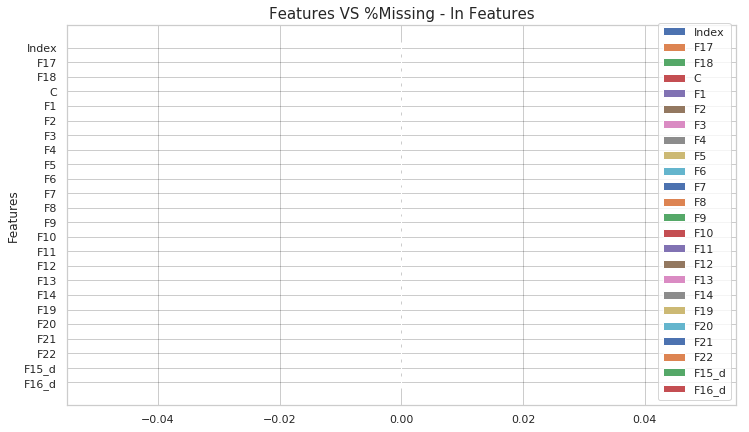

In [7]:
## Handling Missing Obsservation
missing_data = df.isnull().sum(axis=0).reset_index()
missing_data.columns = ['column_name', 'missing_count']
missing_data = missing_data.loc[missing_data['missing_count']>0]
missing_data = missing_data.sort_values(by='missing_count')
display(missing_data)

tempDF = pd.concat([df_info['Categorical'], df_info['Numerical']], sort=False)
featName = list(tempDF.index)
missingPct = list(tempDF['%Missing'])
plotFeatureAndProperty(featName, missingPct, featName, tit='%Missing')

## Missing Data interpolation
# Available methods in interpolate  #https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate
# method : {‘linear’, ‘time’, ‘index’, ‘values’, ‘nearest’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘barycentric’, ‘krogh’, ‘polynomial’, ‘spline’, ‘piecewise_polynomial’, ‘from_derivatives’, ‘pchip’, ‘akima’}
# sum(azdiasPart2['ALTERSKATEGORIE_GROB'].interpolate(method='linear').isna())

#### Disccussion
There is no column having any missing value. Hence, Nothing to do here 


<h3><left> Feature Scaling </h3>


	_________ _________| Before Scaling |________ _________


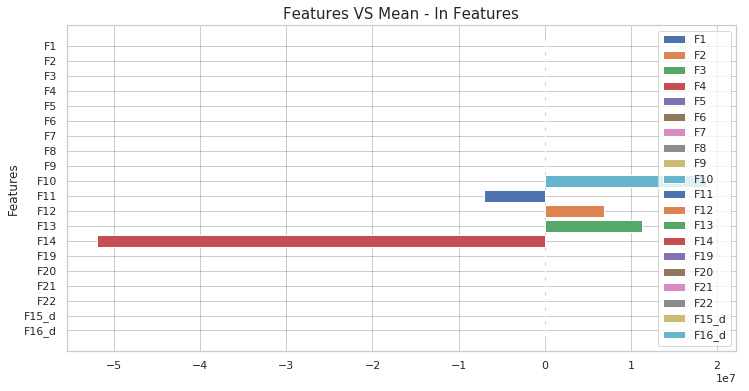

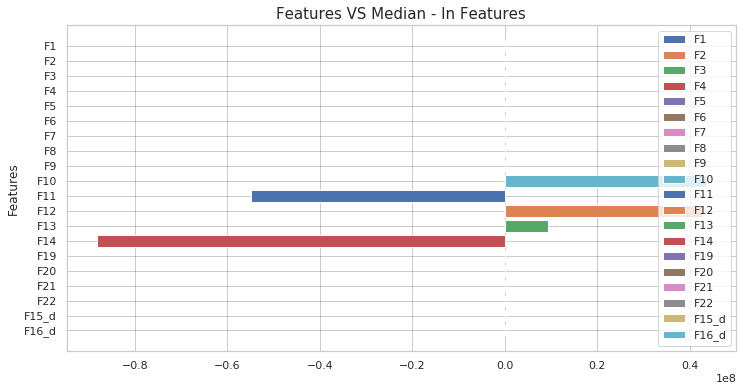

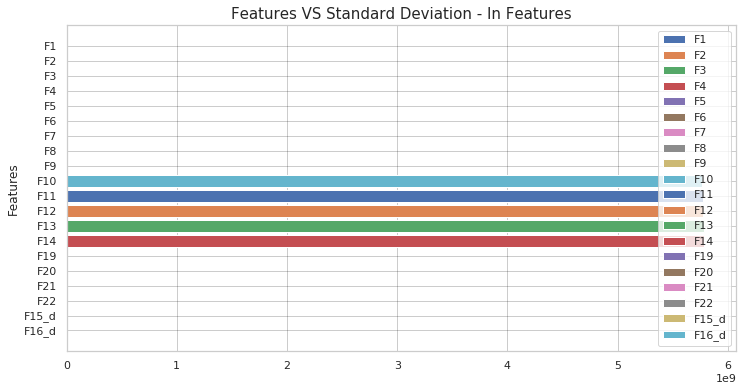

Scaling Feature
Scaling dataframe using Standardization scaler
|	 F1
|	 F2
|	 F3
|	 F4
|	 F5
|	 F6
|	 F7
|	 F8
|	 F9
|	 F10
|	 F11
|	 F12
|	 F13
|	 F14
|	 F19
|	 F20
|	 F21
|	 F22
|	 F15_d
|	 F16_d

	________ _________| After Scaling |________ _________


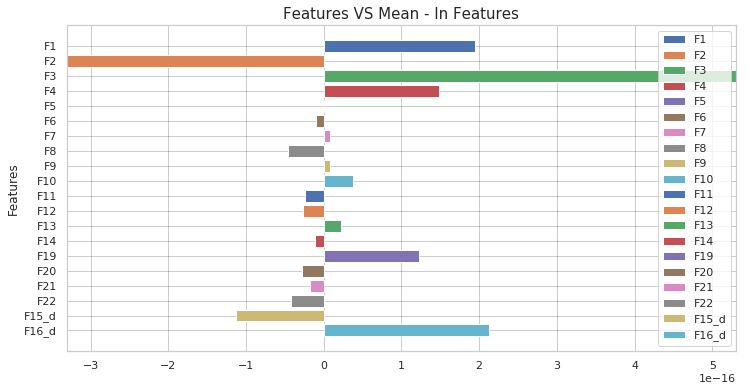

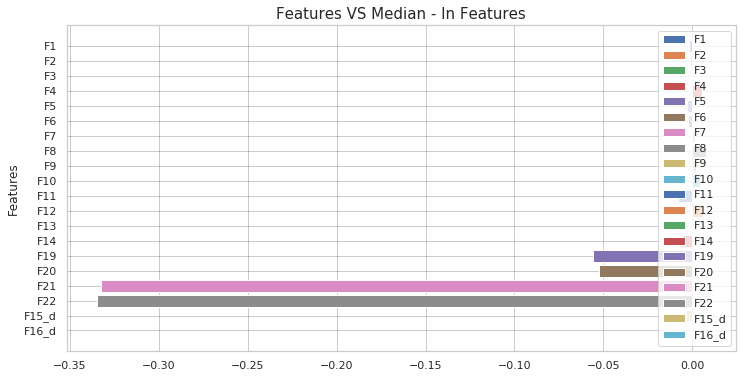

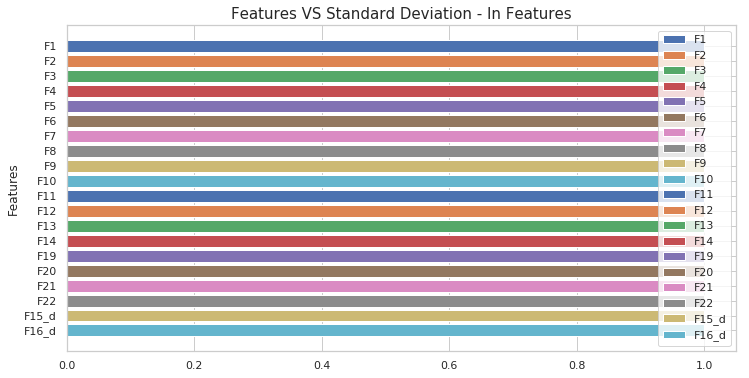

In [8]:
def generatePlots(df_info):
    ## way 1 -- using return dictionary from scaler
    # featName = list(iniDescStats_dict.keys())
    # mea = [ iniDescStats_dict[f]['Mean'] for f in feat ]
    ## way 2 -- using df_info from primary analysis
    featName = list(df_info['Numerical'].index)
    mea = list(df_info['Numerical']['mean'] )
    plotFeatureAndProperty(featName, mea, featName, tit='Mean')
    med = list(df_info['Numerical']['50%'])
    plotFeatureAndProperty(featName, med, featName, tit='Median')    
    std = list(df_info['Numerical']['std'] )
    plotFeatureAndProperty(featName, std, featName, tit='Standard Deviation')

## Standard Scaling
df_info = datasetPrimAnalysis(df, msg=False)
print('\n\t_________ _________| Before Scaling |________ _________')
generatePlots(df_info)

print('Scaling Feature')
scaler = ScalingDF(df.loc[:, df_info['Numerical'].index ])
df.loc[:, df_info['Numerical'].index ], iniDescStats_dict = scaler.standardization()
# finDescStats_dict = scaler.generateNewFeaturesDescriptiveStats()

# again checking the structure
df_info = datasetPrimAnalysis(df, msg=False)
print('\n\t________ _________| After Scaling |________ _________')
generatePlots(df_info)


<h3><left> Dummy Feature Creation </h3>

In [9]:
colToTransform = ['F17', 'F18']

#<todo> write a custom processing class 
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# le = LabelEncoder()
# for feature in nonnumeric_columns:
#     data[feature] = le.fit_transform(data[feature])

# onehotencoder = OneHotEncoder(categorical_features = [1])
# X = onehotencoder.fit_transform(X).toarray()

## OneHot Encoding using a different method
df = df.join(pd.get_dummies(df.loc[:, colToTransform], prefix=None, prefix_sep='_'))
df.drop(columns=colToTransform, inplace=True)

## Reordering the columns
''' will do later -- not needed'''

' will do later -- not needed'

<h3><left> Handling Outlier</h3>

Some columns data is missing b/c of data type
Performing univariate outlier detection
|	Feature "F1" contains 0 outlier cases.
|	Feature "F2" contains 0 outlier cases.
|	Feature "F3" contains 0 outlier cases.
|	Feature "F4" contains 0 outlier cases.
|	Feature "F5" contains 0 outlier cases.
|	Feature "F6" contains 0 outlier cases.
|	Feature "F7" contains 0 outlier cases.
|	Feature "F8" contains 0 outlier cases.
|	Feature "F9" contains 0 outlier cases.
|	Feature "F10" contains 0 outlier cases.
|	Feature "F11" contains 0 outlier cases.
|	Feature "F12" contains 0 outlier cases.
|	Feature "F13" contains 0 outlier cases.
|	Feature "F14" contains 0 outlier cases.
|	Feature "F19" contains 0 outlier cases.
|	Feature "F20" contains 0 outlier cases.
|	Feature "F21" contains 3298 outlier cases.
Data type of series1 and series2: float64 and object
----------------------------------------------------------------------------------------------------
UniVariate Plot
------------------------------------

<Figure size 640x480 with 0 Axes>

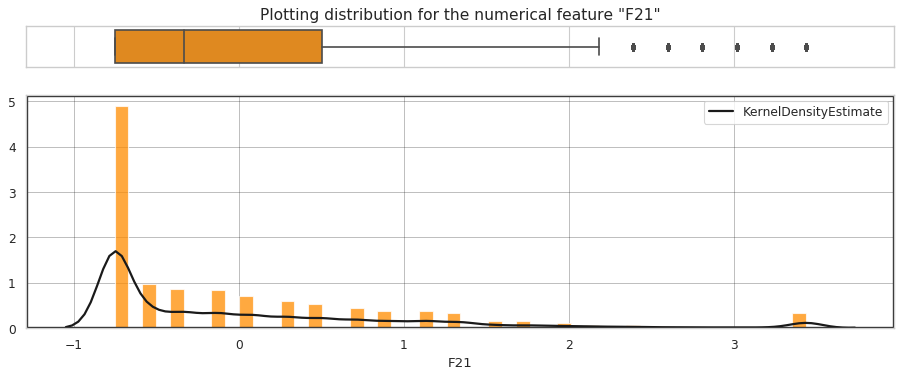

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
BiVariate Plot
----------------------------------------------------------------------------------------------------


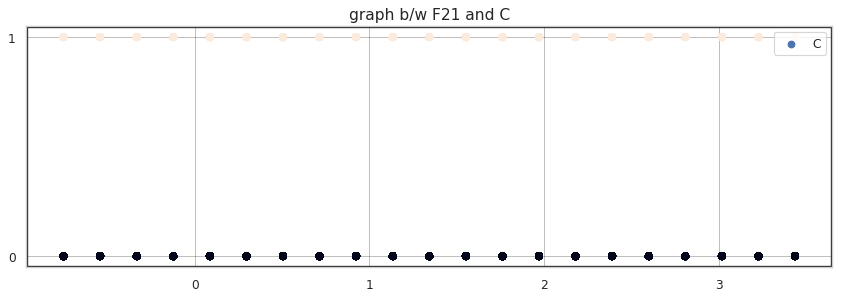

----------------------------------------------------------------------------------------------------
|	Feature "F22" contains 3319 outlier cases.
Data type of series1 and series2: float64 and object
----------------------------------------------------------------------------------------------------
UniVariate Plot
----------------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

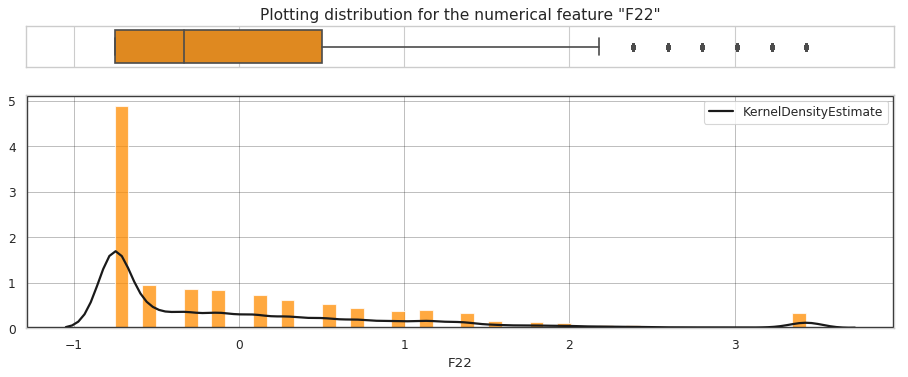

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
BiVariate Plot
----------------------------------------------------------------------------------------------------


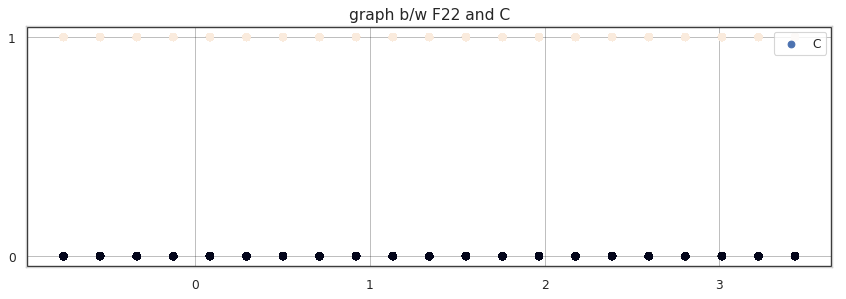

----------------------------------------------------------------------------------------------------
|	Feature "F15_d" contains 265 outlier cases.
Data type of series1 and series2: float64 and object
----------------------------------------------------------------------------------------------------
UniVariate Plot
----------------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

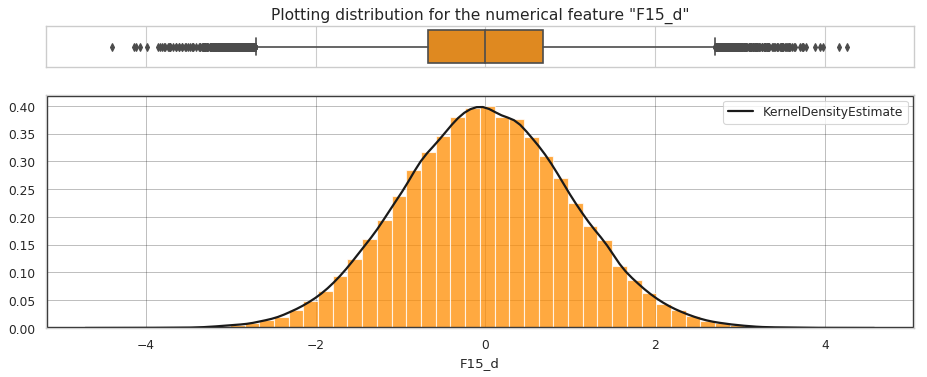

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
BiVariate Plot
----------------------------------------------------------------------------------------------------


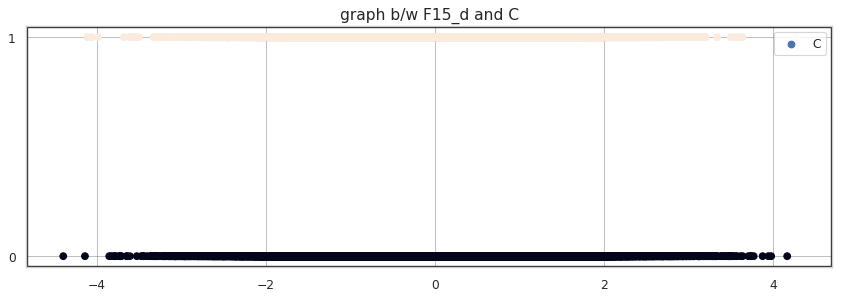

----------------------------------------------------------------------------------------------------
|	Feature "F16_d" contains 295 outlier cases.
Data type of series1 and series2: float64 and object
----------------------------------------------------------------------------------------------------
UniVariate Plot
----------------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

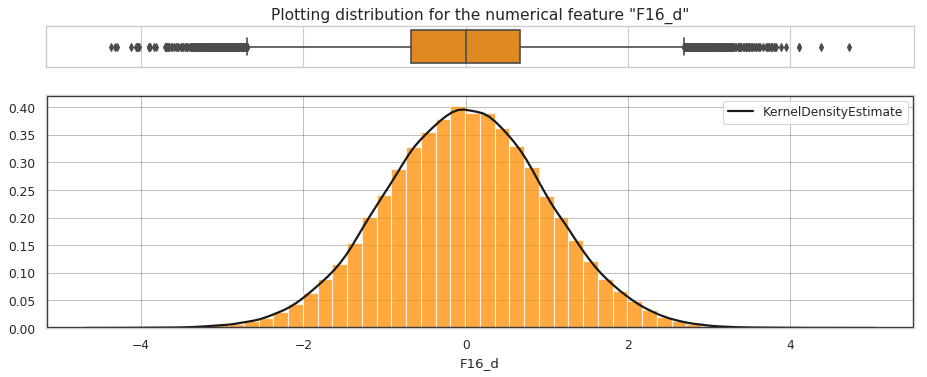

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
BiVariate Plot
----------------------------------------------------------------------------------------------------


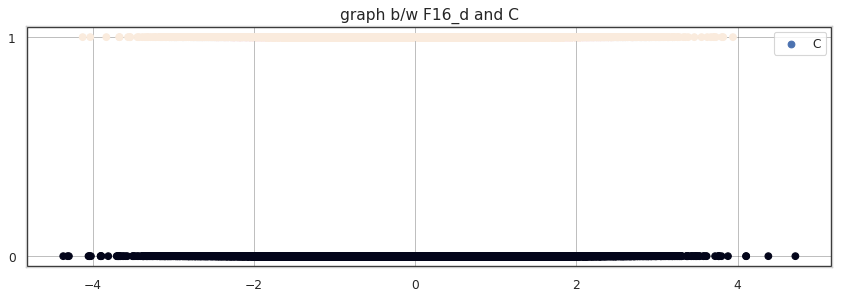

----------------------------------------------------------------------------------------------------


In [10]:
## Univariate Outliers Detection
def outlier_zScore_series(ser, threshold = 3):
    ser_mean, ser_std = ser.mean(), ser.std()
    ser = list(ser)
    if ser_std != 0:
        #return [ True if abs((ele - ser_mean)/ser_std) > threshold else False for ele in ser ] 
        return [ i for i in range(len(ser)) if abs((ser[i] - ser_mean)/ser_std) > threshold ] 
    else:
        raise Exception('Dividing by zero')

## <todo> IQR based

outlier_index_list, feature_having_out = [], []
df_info = datasetPrimAnalysis(df, msg=False)
print('Performing univariate outlier detection')
for feat in df_info['Numerical'].index:
    detected_obs_ind = outlier_zScore_series(df[feat])
    [ outlier_index_list.append(ele) for ele in detected_obs_ind ]
    print('|\tFeature "{}" contains {} outlier cases.'.format(feat, len(detected_obs_ind)))
    if len(detected_obs_ind) > 0: 
        feature_having_out.append( (feat,len(detected_obs_ind)) )
        visualizeFeature(df[feat], df['C'])
# print(outlier_index_list)

#### Discussion
There are 4 features (F21, F22, F15_d,  & F16_d) which gets highlighted in univated outlier detection. This univariate outlier detection is performed by using zscore as a mean to detect oulier. If the absolute value of z-score for a feature is greater than 3 then that feature is considered a outlier.

From the plots and stats highlighted above it can be understood that because of the nature of the data we are accounting for so many data point as outliers. Additionally, based on their distributions these points are not to be considered as outliers. Hence we won't be dropping these features.

In [11]:
## Outlier Removal
# counting the number of feature that marked an index to  be labelled as outlier
ind_dict = {} # will contain key = index & value = # of feature satisfying conditions
for ke in outlier_index_list:
    if ke in ind_dict.keys():
        ind_dict[ke] += 1
    else:
        ind_dict[ke] = 1

if len(ind_dict.keys()) < 10:
    print('Indexes that have been marked as outlier and by how many features', ind_dict)
else:
    indME3 = [ (key, ind_dict[key]) for key in ind_dict.keys() if ind_dict[key] >= 3 ]
    indME2 = [ (key, ind_dict[key]) for key in ind_dict.keys() if ind_dict[key] == 2 ]
    indME1 = [ (key, ind_dict[key]) for key in ind_dict.keys() if ind_dict[key] == 1 ]
    if (len(indME2)>0) | (len(indME3)>0):
        print('Indexes that have been marked as outlier:')
        if len(indME3)>0:
            print('|\tBy more than or equal to 3 feature :', indME3)
        if len(indME2)>0:
            print('|\tBecause of any 2 feature :', indME2)
        #if len(indME1)>0:
        #    print('|\tBecause of any 1 feature :', indME1)
    
# # Removing index which are marked as outlier by any features
# index_to_drop = [ key for key in ind_dict.keys() if ind_dict[key] > 0 ] 
# df.drop(index=index_to_drop, inplace=True)
# df.reset_index(drop=True, inplace=True)

Indexes that have been marked as outlier:
|	Because of any 2 feature : [(340, 2), (1122, 2), (1245, 2), (1410, 2), (1743, 2), (2794, 2), (2896, 2), (3669, 2), (4497, 2), (4676, 2), (4921, 2), (5879, 2), (5939, 2), (6694, 2), (7245, 2), (7307, 2), (7474, 2), (8185, 2), (8755, 2), (9351, 2), (9972, 2), (10648, 2), (11143, 2), (11381, 2), (12208, 2), (12673, 2), (15069, 2), (16336, 2), (16769, 2), (18013, 2), (18017, 2), (18201, 2), (18427, 2), (18863, 2), (19156, 2), (19877, 2), (19907, 2), (20890, 2), (20940, 2), (21381, 2), (21824, 2), (22584, 2), (23535, 2), (24096, 2), (24534, 2), (24547, 2), (26869, 2), (26905, 2), (27235, 2), (27791, 2), (30992, 2), (32785, 2), (34555, 2), (34685, 2), (34951, 2), (36350, 2), (36481, 2), (36543, 2), (37449, 2), (37634, 2), (38107, 2), (38767, 2), (38939, 2), (39011, 2), (39668, 2), (40130, 2), (40193, 2), (43179, 2), (43997, 2), (44253, 2), (45359, 2), (45863, 2), (47143, 2), (47370, 2), (47950, 2), (48042, 2), (49098, 2), (49226, 2), (49591, 2), (5

In [12]:
## Multivariate Outlier Detection - Anomaly Detection
# <todo>


<h3><left> Checking Corelation </h3>

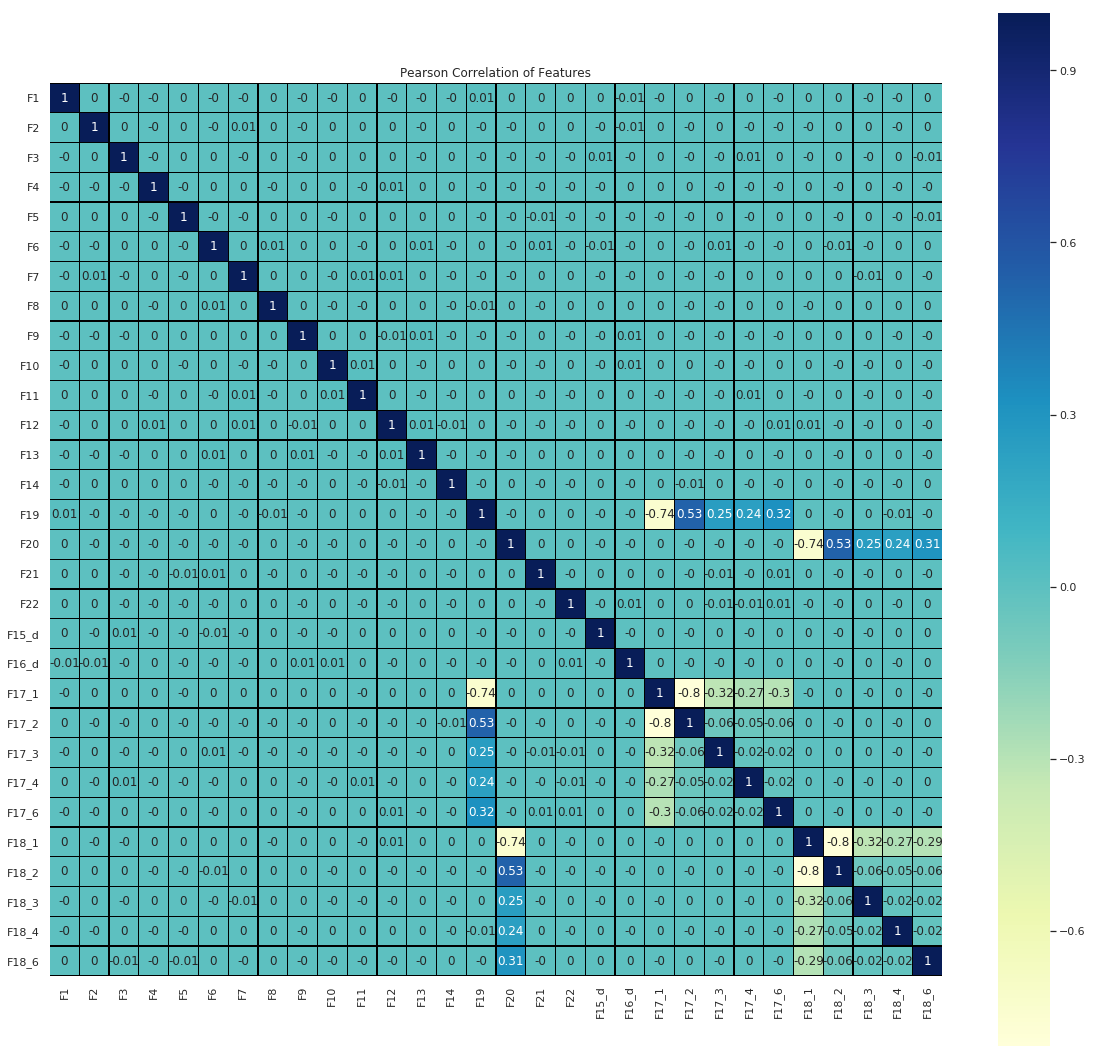

In [13]:
## generating correlation matrix
def generate_correlation_plot(DF, method='pearson'):
    '''
    Use to Generate Confusion Matrix and Storing the confusion matrix
    method : {‘pearson’, ‘kendall’, ‘spearman’} 
    '''
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 19))
    plt.title('Pearson Correlation of Features')
    # Draw the heatmap using seaborn
    sns.heatmap(DF.corr(method=method).round(2),linewidths=0.25,vmax=1.0, square=True, 
                cmap="YlGnBu", linecolor='black', annot=True)
    plt.show()
#     f.savefig(config['input']['ClustFileSavingLoc_dir'] + 'CorrelationPlot__{}.png'.format(time.time()), bbox_inches="tight")

generate_correlation_plot(df)

#### Discussion 
Highly uncorrelated features

Data type of series1 and series2: float64 and float64
----------------------------------------------------------------------------------------------------
UniVariate Plot
----------------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

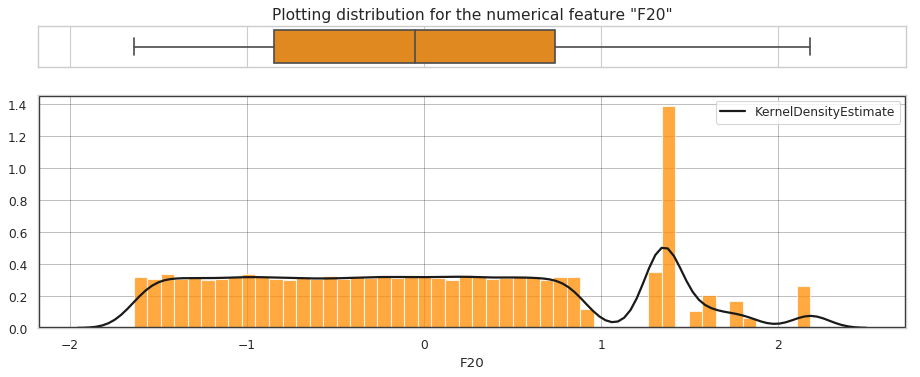

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
BiVariate Plot
----------------------------------------------------------------------------------------------------


No handles with labels found to put in legend.


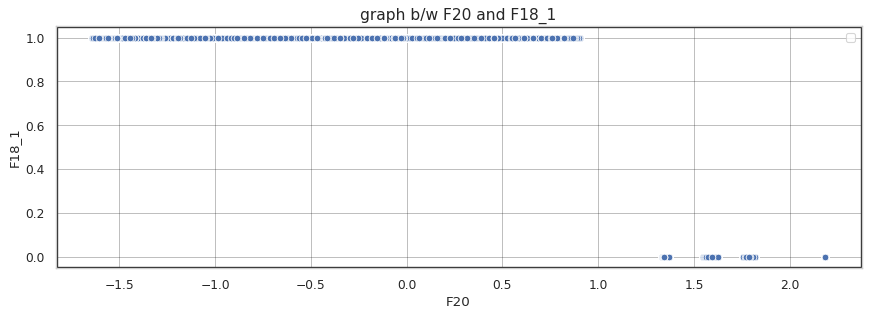

----------------------------------------------------------------------------------------------------


In [14]:
visualizeFeature(df['F20'], df['F18_1'].astype(float))

<h3><left> Class Balancing</h3>

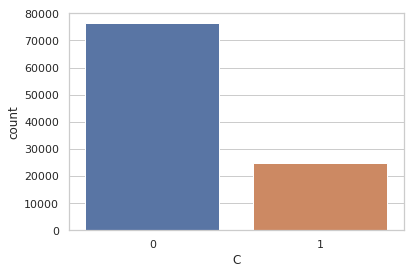

In [15]:
## Critical Class 
sns.countplot(x= df['C'])
plt.show()

In [16]:
'''Not Required'''#<todo>

'Not Required'

<h3><left> Splitting Dataset</h3>

In [17]:
# Splitting the dataset into the Training set and Test set
## Dividing the data into X and Y
x = df.loc[:, df.columns != 'C'].copy()
y = df['C']

## Changing Mapping
# level_map = {'1':'Purchased', '0':'NotPurchased'}
# y['C'].map(level_map)

## Changing Datatype of Critical Class
y = y.astype(int)

## Splitting the dataset
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 0)

print('length of train and test set :', len(xtrain), len(xtest) )

length of train and test set : 80944 20236


<h2><left> Repeating the Data Cleaning steps on New Data</h2>

In [18]:
def dataCleaningFunction(df, predictInfo=None):
    df = df.copy()
    cycle = 'Train' if predictInfo == None else 'Predict'
    print('\n', cycle)
    
    ## datetime based feature
    feat_dt = ['F15', 'F16']
    for f in feat_dt: df[f] = pd.to_datetime(df[f],format='%m/%d/%Y')
    ## Categorical Features
    feat_str = ['Index']
    feat_str += ['F5', 'F6', 'F7', 'F8', 'F9']
    feat_str += ['F17', 'F18']
    feat_str += ['F19', 'F20']
    feat_str += ['F21', 'F22']
    if cycle == 'Train': feat_str += ['C']
    # Converting feature datatype to Object
    for f in feat_str: df[f] = df[f].astype(str)
    #df_info = datasetPrimAnalysis(df)

    ## Converting Information Type
    df['F15_d'] = [ ele.timestamp() / (60*60*24) for ele  in df['F15'] ]
    df['F16_d'] = [ ele.timestamp() / (60*60*24) for ele  in df['F16'] ] 
    # To Numeric
    feat_num = ['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12',\
                'F13','F14','F15_d','F16_d','F19','F20','F21','F22']
    for f in feat_num: df[f] = df[f].astype(float)
    # To Object
    if cycle == 'Train': 
        feat_str = ['Index','F17','F18','C']
    else:
        feat_str = ['Index','F17','F18']
    for f in feat_str: df[f] = df[f].astype(str)
    ## Dropping some certain features
    df.drop(columns=['F15', 'F16'], inplace=True) #'Index' is valuable for sub_df hence won't be dropped at this stage
    df_info = datasetPrimAnalysis(df, msg=False)
    
    if cycle == 'Train': df.drop(columns=['Index'], inplace=True)
    
    ## Handling Missing Obsservation
    '''Nothing to Do'''
    
    ## Feature Scaling
    if cycle == 'Train':
        predictInfo = {}
        scaler = ScalingDF(df.loc[:, df_info['Numerical'].index ])
        df.loc[:, df_info['Numerical'].index ], predictInfo['scalerDict'] = scaler.standardization()
    else:
        scaler = ScalingDF(df.loc[:, df_info['Numerical'].index ], predictInfo['scalerDict'])
        df.loc[:, df_info['Numerical'].index ], iniDescStats_dict = scaler.standardization()
    df_info = datasetPrimAnalysis(df, msg=False)    
    
    ## Dummy Feature Creation
    colToTransform = ['F17', 'F18']
    df = df.join(pd.get_dummies(df.loc[:, colToTransform], prefix=None, prefix_sep='_'))
    df.drop(columns=colToTransform, inplace=True)
    
    ## Handling Outlier
    '''Nothing to Do'''
    
    ## Class Balance & Splitting Dataset
    '''Nothing to Do'''
    
    return df, predictInfo


# cleanDF, predictInfo = dataCleaningFunction(df)
# xSubDF, predictInfo = dataCleaningFunction(sub_df, predictInfo=predictInfo)

dictToPassForPred = {}
dictToPassForPred['scalerDict'] = iniDescStats_dict
xSubDF, predictInfo = dataCleaningFunction(sub_df, predictInfo=dictToPassForPred)
xSubDF.head()


 Predict
Scaling dataframe using Standardization scaler
|	 F1
|	 F2
|	 F3
|	 F4
|	 F5
|	 F6
|	 F7
|	 F8
|	 F9
|	 F10
|	 F11
|	 F12
|	 F13
|	 F14
|	 F19
|	 F20
|	 F21
|	 F22
|	 F15_d
|	 F16_d


Index        F1        F2        F3        F4        F5        F6  \
0  T30234341  0.529119  1.074376  0.357606 -0.376822 -0.897684  0.832125   
1  T30234342  0.667533  0.654188 -0.091479 -0.831502 -0.101742 -0.865941   
2  T30234343 -1.036557 -0.616558 -0.026281 -1.691520 -1.513060  1.059155   
3  T30234344 -0.634319 -0.744767  1.406528 -1.406157 -1.366221  0.771054   
4  T30234345 -0.924621  0.973255 -0.741489 -0.402640 -0.564918  0.787098   

         F7        F8        F9  ...    F17_1  F17_2  F17_3  F17_4  F17_6  \
0 -0.310799  1.284941 -1.240153  ...        1      0      0      0      0   
1  0.347590  1.598284  1.604066  ...        1      0      0      0      0   
2  1.206654  0.649783  0.743904  ...        1      0      0      0      0   
3  1.336736  1.647395  0.056329  ...        1      0      0      0      0   
4 -0.275417 -1.482919 -0.006399  ...        1      0      0      0      0   

   F18_1  F18_2  F18_3  F18_4  F18_6  
0      1      0      0      0      0  
1      1      0      0      0      0  
2      1      0      0      0      0  
3      1      0      0      0      0  
4      1      0      0      0      0  

[5 rows x 31 columns]

<h1><center><u> Parameter Tuning </u></h1>

### Parameter Tuning is performed on the following algo
- Random Forest
- XGBoost


<h3><left> Random Forest - Gini and Entropy metric</h3>

Parameters Value :
|	 {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': -1, 'oob_score': False, 'random_state': 12345, 'verbose': 0, 'warm_start': False}
_________________________On Test Data_________________________

Model Performance
Average Error: 0.2601 degrees.
Accuracy = 73.99%.
Mattheaw Correlation Coefficient = 0.100.


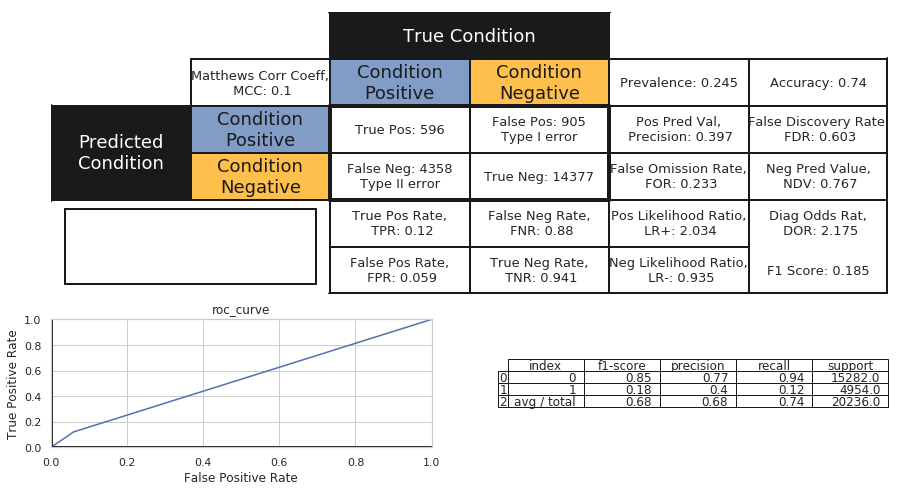

In [19]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    #mape = 100 * np.mean(errors / test_labels)
    accuracy = accuracy_score(test_labels, predictions)*100# 100 - mape
    mcc = matthews_corrcoef(test_labels, predictions)
    # MattheawCorrelationCoefficient = round((tp*tn - fp*fn) / ((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**(1/2),3)
    print('\nModel Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('Mattheaw Correlation Coefficient = {:0.3f}.'.format(mcc))
    return accuracy, mcc

base_model = RandomForestClassifier(criterion = 'gini',n_jobs = -1, random_state = seed)
base_model.fit(xtrain, ytrain)
print('Parameters Value :\n|\t', base_model.get_params())
print('_'*25+'On Test Data'+'_'*25)
base_accuracy, base_mcc = evaluate(base_model, xtest, ytest)
plotConfusionMatrix(y_act=ytest, y_pred=base_model.predict(xtest))

In [20]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'criterion': ['gini'], #, 'entropy'
    'bootstrap': [True],
    'max_depth': [None], #120(highlighted), 130
    'max_features': ['auto'], #4(highlighted)
    'min_samples_leaf': [1], #6(highlighted), 8
    'min_samples_split': [2], #17(highlighted), 18
    'n_estimators': [2, 4, 6, 8, 10] #100(highlighted)
    ## default:  'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 
    ##           'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 
    ##           'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 
    ##           'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 
    ##           'n_jobs': -1, 'oob_score': False, 'random_state': 12345, 'verbose': 0, 
    ##           'warm_start': False
}
# Create a based model
rfc = RandomForestClassifier(n_jobs = -1, random_state = seed)
# Instantiate the grid search model
# ref:https://scikit-learn.org/stable/modules/model_evaluation.html  #,scoring='f1'
grid_search_rf = GridSearchCV(estimator = rfc, param_grid = param_grid, scoring='roc_auc', 
                           cv = 3, n_jobs = -1, verbose = 1, return_train_score=True)

# Fit the grid search to the data
grid_search_rf.fit(xtrain, ytrain) 

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   15.2s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=12345, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'criterion': ['gini'], 'bootstrap': [True], 'max_depth': [None], 'max_features': ['auto'], 'min_samples_leaf': [1], 'min_samples_split': [2], 'n_estimators': [2, 4, 6, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [21]:
## grid_search.grid_scores_ ----> grid_search.cv_results_
print('Train Score')
print(grid_search_rf.cv_results_['mean_train_score'])
print(grid_search_rf.cv_results_['std_train_score'])
print('Test Score')
print(grid_search_rf.cv_results_['mean_test_score'])
print(grid_search_rf.cv_results_['std_test_score'])

Train Score
[0.93254705 0.98364754 0.99506401 0.99835616 0.99937912]
[1.18769744e-03 1.37827642e-04 3.99018988e-06 3.30989404e-05
 3.44112641e-05]
Test Score
[0.59297748 0.63167269 0.65120152 0.66133352 0.6693709 ]
[0.00283892 0.00210944 0.00184293 0.00131481 0.00193853]


In [22]:
# Best params
best_parameters_rf, score_rf, _ = max(grid_search_rf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score_rf)
for param_name in sorted(best_parameters_rf.keys()):
    print("%s: %r" % (param_name, best_parameters_rf[param_name]))
print('\nBest Parameter Combination: \n|\t',grid_search_rf.best_params_)

Raw AUC score: 0.669370902621917
bootstrap: True
criterion: 'gini'
max_depth: None
max_features: 'auto'
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 10

Best Parameter Combination: 
|	 {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}


_________________________On Test Data_________________________

Model Performance
Average Error: 0.2601 degrees.
Accuracy = 73.99%.
Mattheaw Correlation Coefficient = 0.100.


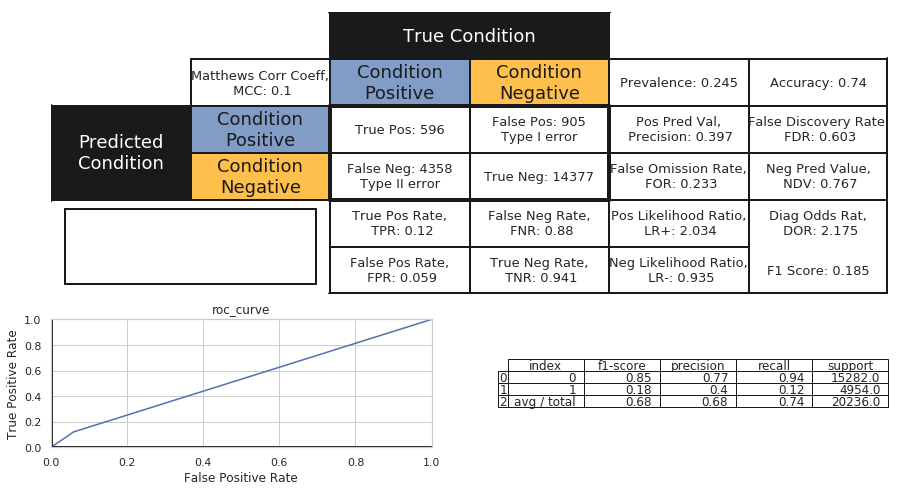


Improvement in Accuracy is 0.00%.
Improvement in Mattheaw Correlation Coefficient is 0.00%.


In [23]:
## Evaluating
print('_'*25+'On Test Data'+'_'*25)
best_grid = grid_search_rf.best_estimator_
grid_accuracy, grid_mcc = evaluate(best_grid, xtest, ytest)
plotConfusionMatrix(y_act=ytest, y_pred=best_grid.predict(xtest))

print('\nImprovement in Accuracy is {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))
print('Improvement in Mattheaw Correlation Coefficient is {:0.2f}%.'.format( 100 * (grid_mcc - base_mcc) / base_mcc))



#### Discussion 
Even Though Accuracy and MCC has reduce still we have been able to increase the TP

<h3><left> XGBoost - F1 score metric</h3>

Parameters Value :
|	 {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': -1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 12345, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}
_________________________On Test Data_________________________

Model Performance
Average Error: 0.2437 degrees.
Accuracy = 75.63%.
Mattheaw Correlation Coefficient = 0.057.


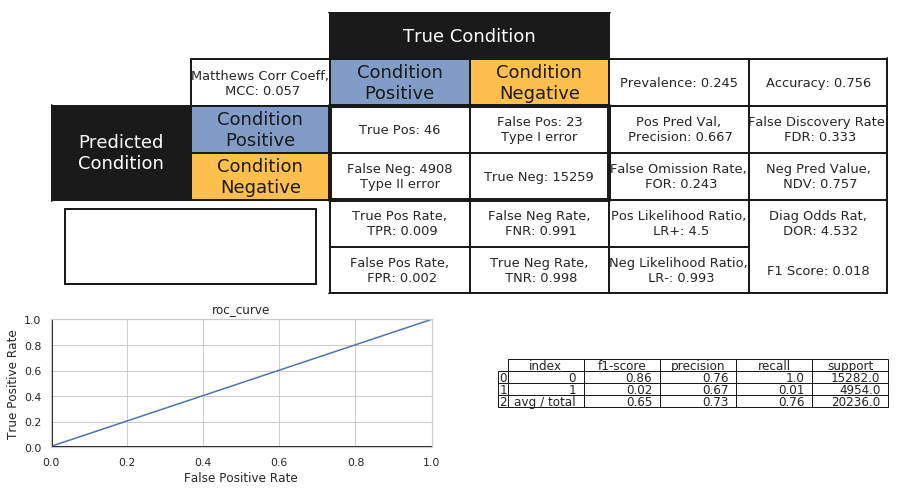

In [24]:
# ## DataTransformation
# dtrain = xgb.DMatrix(data = xtrain, label = ytrain)
# dtest = xgb.DMatrix(data = xtest, label = ytest)
# param = {
#     'max_depth': 3,  # the maximum depth of each tree
#     'eta': 0.3,  # the training step for each iteration
#     'silent': 1,  # logging mode - quiet
#     'objective': 'multi:softprob',  # error evaluation for multiclass training
#     'num_class': 3}  # the number of classes that exist in this datset
# num_round = 20  # the number of training iterations
# base_model = xgb.train(param, dtrain, num_boost_round=num_round)
# ## Using Optimized Parameters
# our_params = { 'objective': 'binary:logistic'} 
# # Grid Search CV optimized settings
# cv_xgb = xgb.cv(params = our_params, dtrain = dtrain, num_boost_round = 3000, nfold = 5,
#                 metrics = ['error'], # Make sure you enter metrics inside a list or you may encounter issues!
#                 early_stopping_rounds = 100, verbose_eval=True)
# cv_xgb.loc[cv_xgb["test-error-mean"] == min(cv_xgb["test-error-mean"])]

base_model = xgb.XGBClassifier(n_jobs = -1, random_state = seed, objective='binary:logistic')
base_model.fit(xtrain, ytrain)
print('Parameters Value :\n|\t', base_model.get_params())
print('_'*25+'On Test Data'+'_'*25)
base_accuracy, base_mcc = evaluate(base_model, xtest, ytest)
plotConfusionMatrix(y_act=ytest, y_pred=base_model.predict(xtest))

In [25]:
ind_params = {
    'objective': 'binary:logistic'
    #'learning_rate': 1,
    #'max_depth': 6,
    #'n_estimators': 100,
    #'gamma': 0, #[0, 1], #[0, 1, 2],
    #'min_child_weight': 1, #[0.5, 1] #[0.5, 1, 1.5]
    #'subsample': 0.7,
    #'colsample_bytree': 0.5
}

cv_params = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [4, 5, 6],
    'subsample': [1],
    'colsample_bytree': [1],
}
'''
Default
max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='binary:logistic', 
booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs
'''


# Create a based model
xgbC = xgb.XGBClassifier(**ind_params)

# Instantiate the grid search model
#SKF = StratifiedKFold(n_splits = 2, shuffle=True)
#SKFold = SKF.split(X_train, y_train)
grid_search_xgb = GridSearchCV(estimator = xgbC, param_grid = cv_params, scoring='roc_auc', n_jobs=-1, verbose=1)
                                 #cv = SKFold, scoring='roc_auc', refit=True

# Fit the grid search to the data
grid_search_xgb.fit(xtrain, ytrain)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  5.1min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [4, 5, 6], 'subsample': [1], 'colsample_bytree': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [26]:
# Best params
best_parameters_xgb, score_xgb, _ = max(grid_search_xgb.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score_xgb)
for param_name in sorted(best_parameters_xgb.keys()):
    print("%s: %r" % (param_name, best_parameters_xgb[param_name]))
print('\nBest Parameter Combination: \n|\t',grid_search_xgb.best_params_)

Raw AUC score: 0.723461076672152
colsample_bytree: 1
learning_rate: 0.1
max_depth: 6
subsample: 1

Best Parameter Combination: 
|	 {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 6, 'subsample': 1}


_________________________On Test Data_________________________

Model Performance
Average Error: 0.2381 degrees.
Accuracy = 76.19%.
Mattheaw Correlation Coefficient = 0.137.


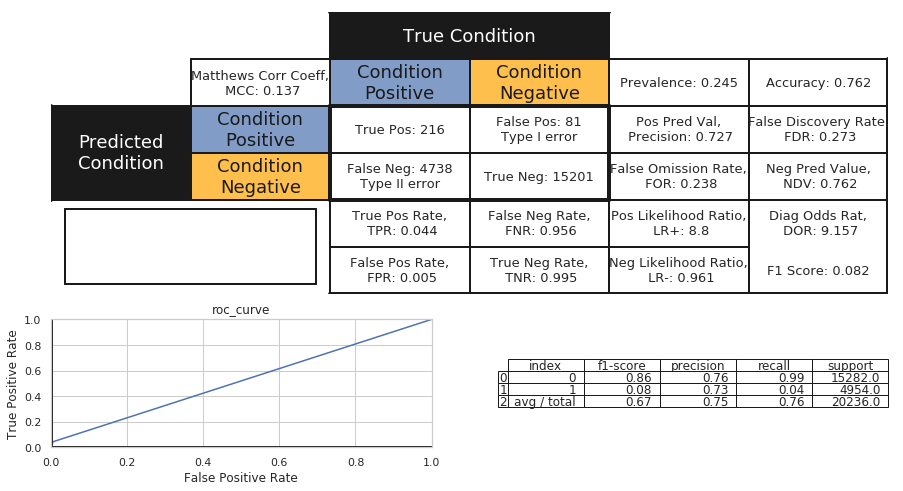


Improvement in Accuracy is 0.73%.
Improvement in Mattheaw Correlation Coefficient is 138.63%.


In [27]:
## Evaluating
print('_'*25+'On Test Data'+'_'*25)
best_grid_xgb = grid_search_xgb.best_estimator_
grid_accuracy, grid_mcc = evaluate(best_grid_xgb, xtest, ytest)
plotConfusionMatrix(y_act=ytest, y_pred=best_grid_xgb.predict(xtest))

print('\nImprovement in Accuracy is {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))
print('Improvement in Mattheaw Correlation Coefficient is {:0.2f}%.'.format( 100 * (grid_mcc - base_mcc) / base_mcc))

# Fitting XGBoost to the Training set
#xgb.cv(params = xgb_params, dtrain = dtrain, num_boost_round = NumRound, nfold=3)

#### Discussion
Using XGB we can see that there's improvement in both Accuracy and Matthew correlation coefficient 

<h1><center><u> Feature Importance </u></h1>

This is also an important part, as this helps in understanding the role and iimportance of features. 
### Computed using
- Random Forest - Gini metric
- Random Forest - Entropy metric
- XGBoost - F score


<h3><left> Random Forest - Gini Index </h3<

In [28]:
rfc = RandomForestClassifier(criterion = 'gini',n_jobs = -1, random_state = seed) #entropy
featTrain = xtrain.columns.values
rfc.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=12345, verbose=0,
            warm_start=False)

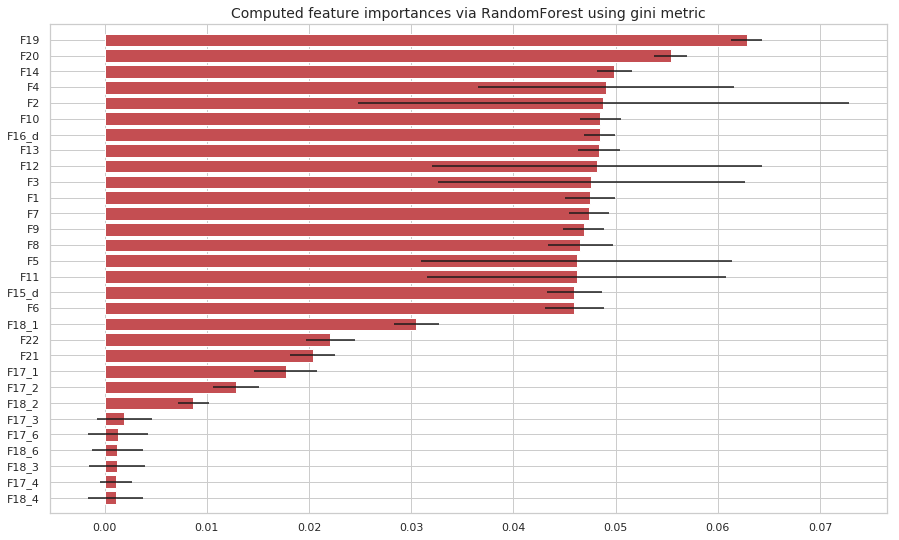

In [29]:
## plot the importances ##
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

## Showing top 50 features
indices = np.argsort(importances)[:50]  #'1234'[::-1] =>>'4321'

plt.figure(figsize=(15, int(len(indices)*0.30)))
plt.barh(range(len(indices)), importances[indices], xerr=std, color="r", align="center")
plt.yticks(range(len(indices)), featTrain[indices], rotation='horizontal')
plt.ylim([-1, len(indices)])
plt.title('Computed feature importances via RandomForest using {} metric'.format(rfc.criterion), fontsize=14)
# plt.gca().invert_yaxis()
plt.show()

_________________________On Training Data_________________________


class  count
0      0  61071
1      1  19873

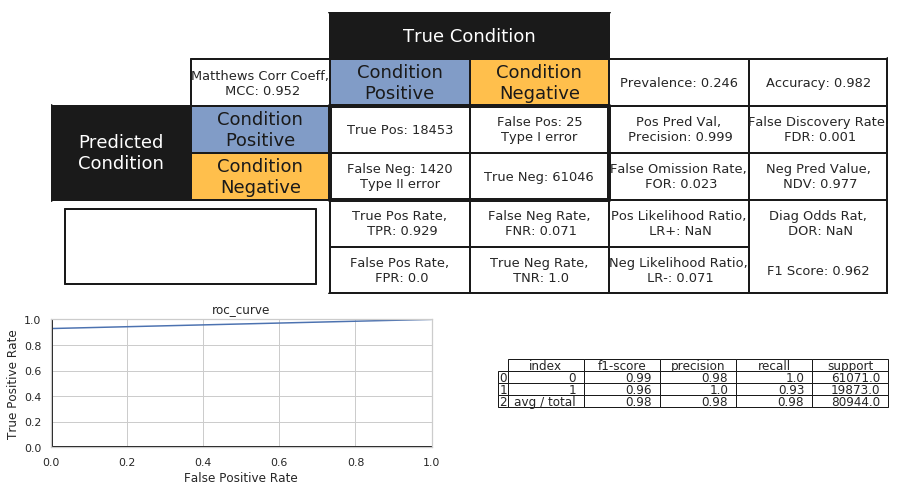

_________________________On Test Data_________________________


class  count
0      0  15282
1      1   4954

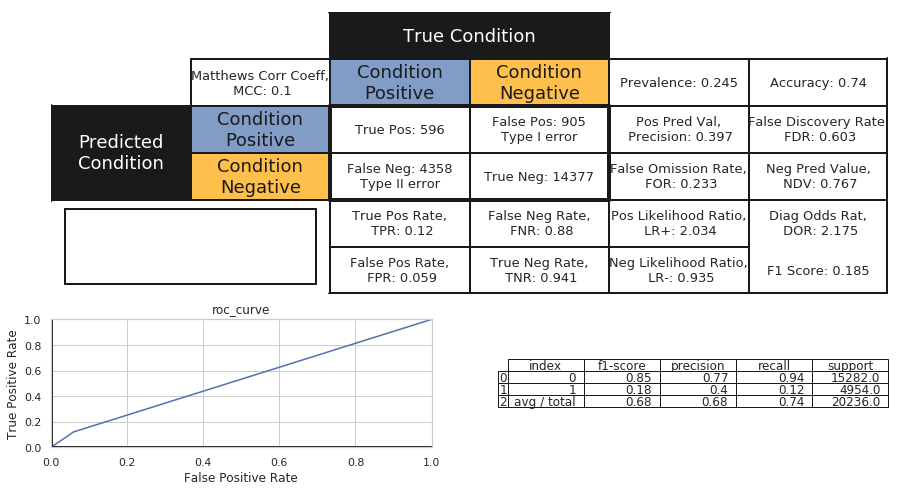

In [30]:
## Plot confusion Matrix
## On Training Data
print('_'*25+'On Training Data'+'_'*25)
display(pd.DataFrame(ytrain.value_counts()).reset_index().rename(columns={'index':'class', 'C':'count'}))
y_pred = rfc.predict(xtrain)
plotConfusionMatrix(y_act=ytrain, y_pred=y_pred)

## On Test Data
print('_'*25+'On Test Data'+'_'*25)
display(pd.DataFrame(ytest.value_counts()).reset_index().rename(columns={'index':'class', 'C':'count'}))
y_pred = rfc.predict(xtest)
plotConfusionMatrix(y_act=ytest, y_pred=y_pred)

# cm = confusion_matrix(ytest, predicted)
# tempDF = pd.DataFrame(cm, columns = ["Human", "Bot"])
# tempDF.index = ["Actually_Human", "Actually_Bot"]
# print("\n\t\t   Predicted\n", tempDF)
# plt.matshow(cm)
# plt.colorbar()

#### Discussion
Random Forest is a Deterministic Algorithm
**Model is not Good (Overfit)/ Input Data is not good** 

<h3><left> Random Forest - Entropy </h3>

In [31]:
rfc = RandomForestClassifier(criterion = 'entropy',n_jobs = -1, random_state = seed)
featTrain = xtrain.columns.values
rfc.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=12345, verbose=0,
            warm_start=False)

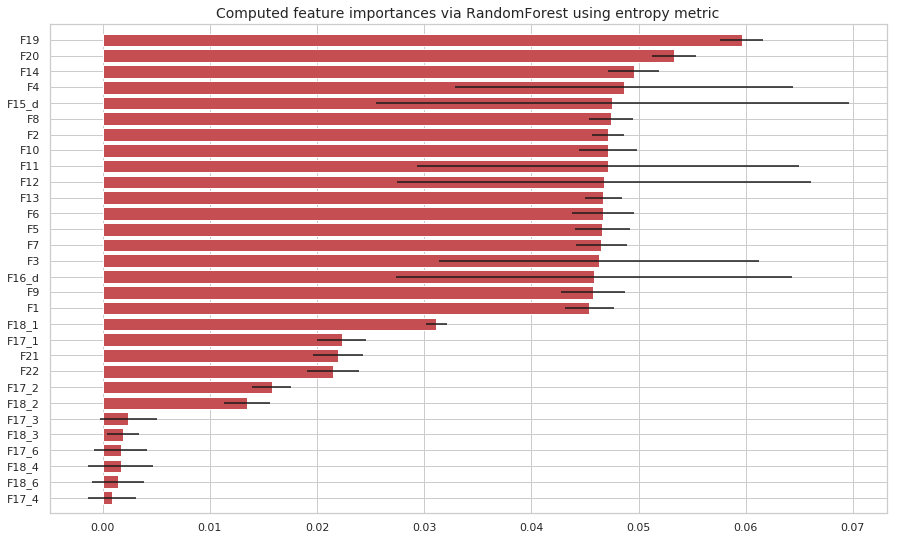

In [32]:
## plot the importances 
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

## Showing top 50 features
indices = np.argsort(importances)[:50]  #'1234'[::-1] =>>'4321'

plt.figure(figsize=(15, int(len(indices)*0.30)))
plt.barh(range(len(indices)), importances[indices], xerr=std, color="r", align="center")
plt.yticks(range(len(indices)), featTrain[indices], rotation='horizontal')
plt.ylim([-1, len(indices)])
plt.title('Computed feature importances via RandomForest using {} metric'.format(rfc.criterion), fontsize=14)
# plt.gca().invert_yaxis()
plt.show()

_________________________On Training Data_________________________


class  count
0      0  61071
1      1  19873

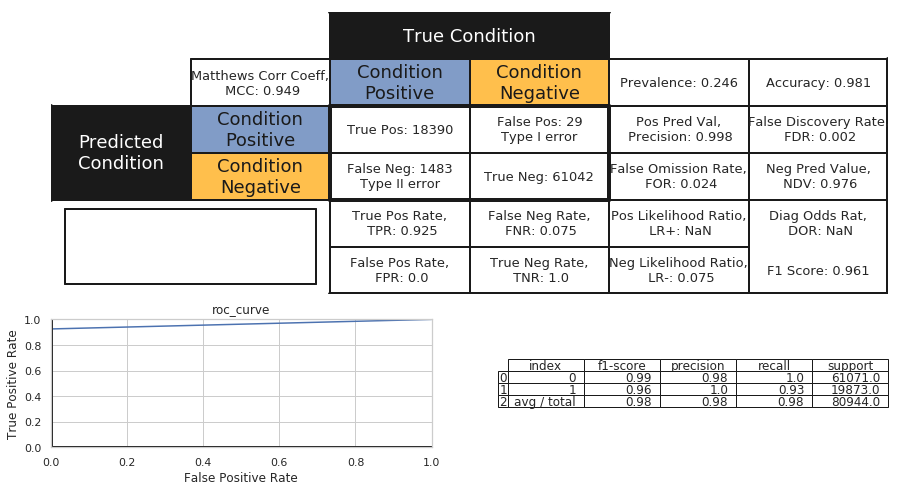

_________________________On Test Data_________________________


class  count
0      0  15282
1      1   4954

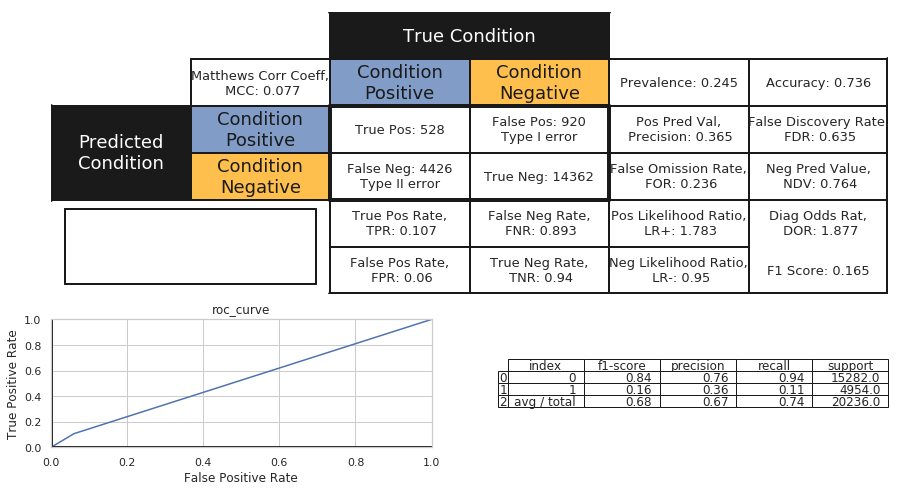

In [33]:
## On Training Data
print('_'*25+'On Training Data'+'_'*25)
display(pd.DataFrame(ytrain.value_counts()).reset_index().rename(columns={'index':'class', 'C':'count'}))
y_pred = rfc.predict(xtrain)
plotConfusionMatrix(y_act=ytrain, y_pred=y_pred)

## On Test Data
print('_'*25+'On Test Data'+'_'*25)
display(pd.DataFrame(ytest.value_counts()).reset_index().rename(columns={'index':'class', 'C':'count'}))
y_pred = rfc.predict(xtest)
plotConfusionMatrix(y_act=ytest, y_pred=y_pred)

# cm = confusion_matrix(ytest, predicted)
# tempDF = pd.DataFrame(cm, columns = ["Human", "Bot"])
# tempDF.index = ["Actually_Human", "Actually_Bot"]
# print("\n\t\t   Predicted\n", tempDF)
# plt.matshow(cm)
# plt.colorbar()

#### Discussion
Random Forest is a Deterministic Algorithm
**Model is not Good (Overfit)/ Input Data is not good** 

<h3><left> XGBoost - F1 score </h3>

In [34]:
params = best_parameters_xgb ## rest can be default
xgbC = xgb.XGBClassifier(**params, random_state=seed, n_jobs=-1)
xgbC.fit(xtrain, ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=12345, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

Computed feature importances via XGBoost using F Score metric


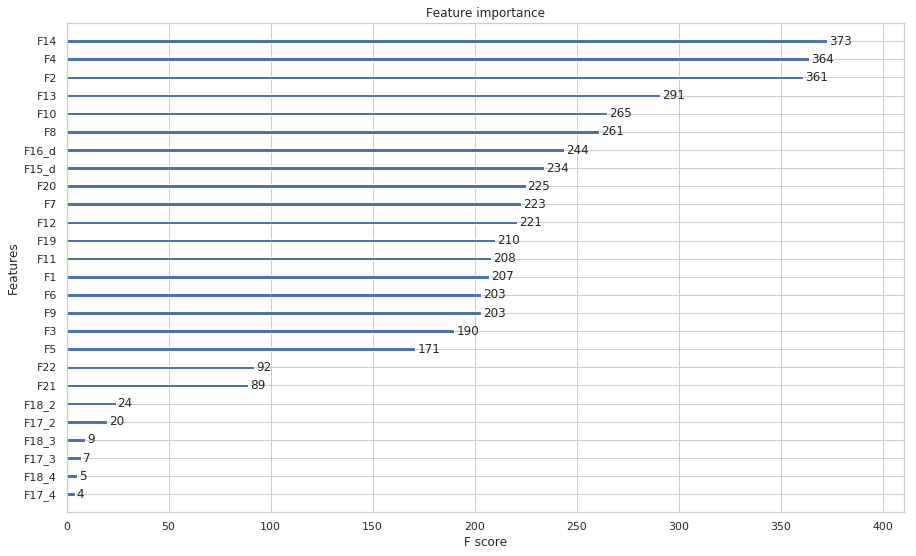

In [35]:
## plot the importances 
ax = xgb.plot_importance(xgbC)
fig = ax.figure
fig.set_size_inches(15, int(len(xtrain.columns.values)*0.30))
print('Computed feature importances via XGBoost using {} metric'.format('F Score'))

### Plotting the Tree

In [36]:
# #!pip install graphviz
# import graphviz 
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
# xgb.plot_tree(FinalXGB_Mod, num_trees=2)
# fig = plt.gcf()
# fig.set_size_inches(350, 80)
# fig.savefig('tree.png')

# xgb.to_graphviz(FinalXGB_Mod, num_trees=2)

<h1><center>Applying Models</h1>

### XGBoost
**Definition**: 

**Advantages**: 

**Disadvantages**: 

In [37]:
## Training the Model
params = best_parameters_xgb ## rest can be default
xgbC = xgb.XGBClassifier(**params, random_state=seed, n_jobs=-1)
xgbC.fit(xtrain, ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=12345, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

/home/mohit/Documents/MyProject/MyProjectVirEnv/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


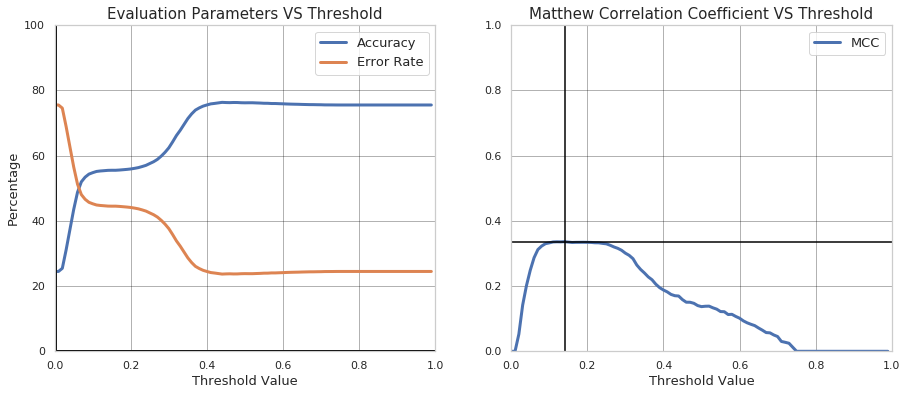

Best Predictive power of the model is when the threshold is around 0.14
Though the accuracy will be low at this threshold ~ 55%


In [38]:
## Testing the Model
# Deterministic Prediction 
# ypred = xgbC.predict(xtest) 
# plotConfusionMatrix(y_act=ytest, y_pred=ypred)

# Stochastic Prediction 
ypred = xgbC.predict_proba(xtest)
ypred = [ ypred[i][1] for i in range(len(ypred)) ]

# Understanding How Accuracy Changes via changing threshold
threshold_best_mcc = plotAccAndErrorWrtThreshold(ytest, ypred) 
print('Best Predictive power of the model is when the threshold is around {}'.format(threshold_best_mcc))
print('Though the accuracy will be low at this threshold ~ 55%')

_________________________On Test Data_________________________
_______________When thershold is 0.05_______________


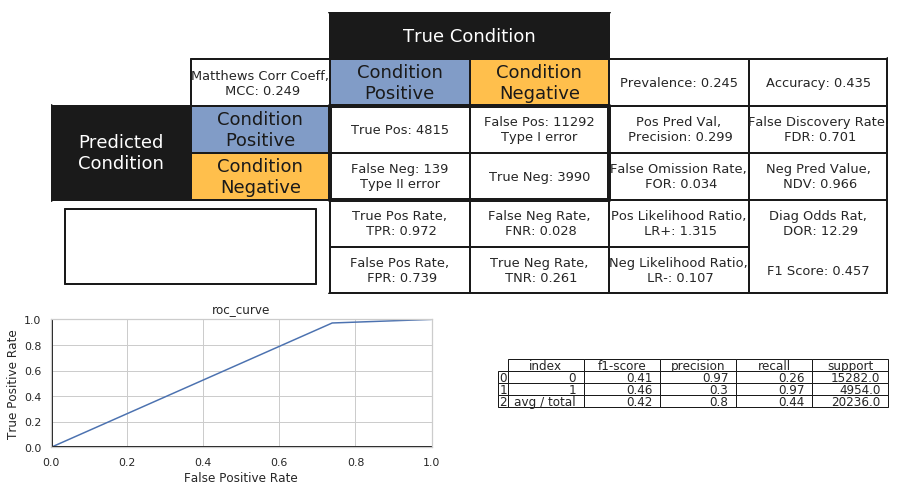

_______________When thershold is 0.1_______________


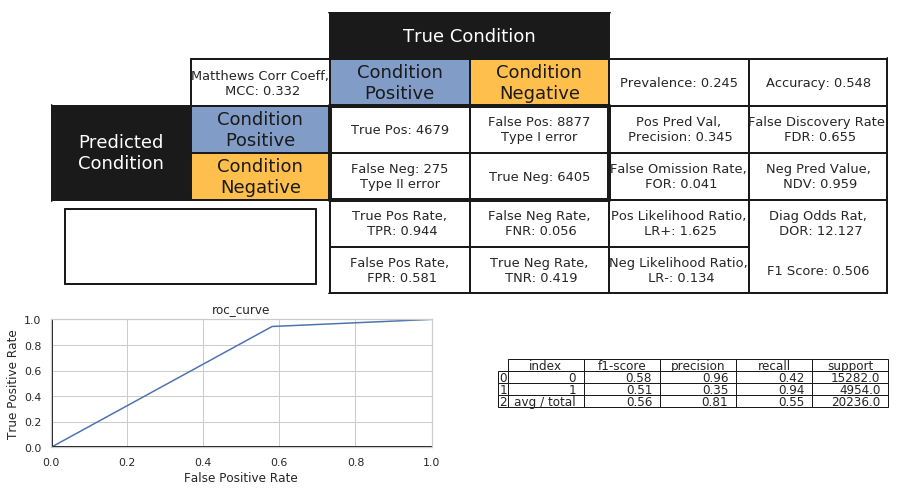

_______________When thershold is 0.15_______________


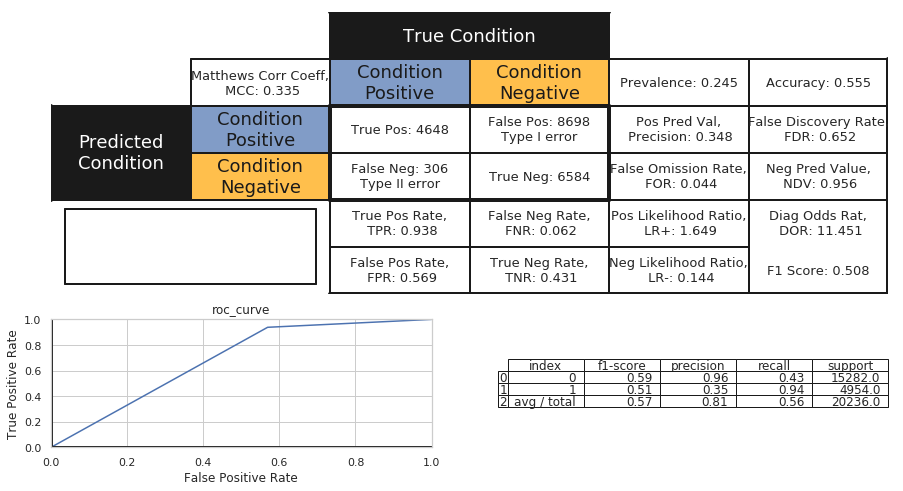

_______________When thershold is 0.2_______________


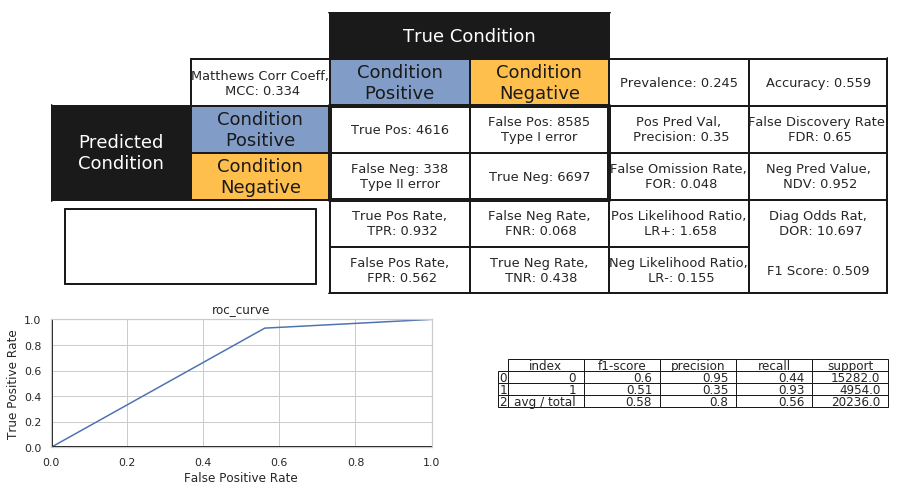

_______________When thershold is 0.25_______________


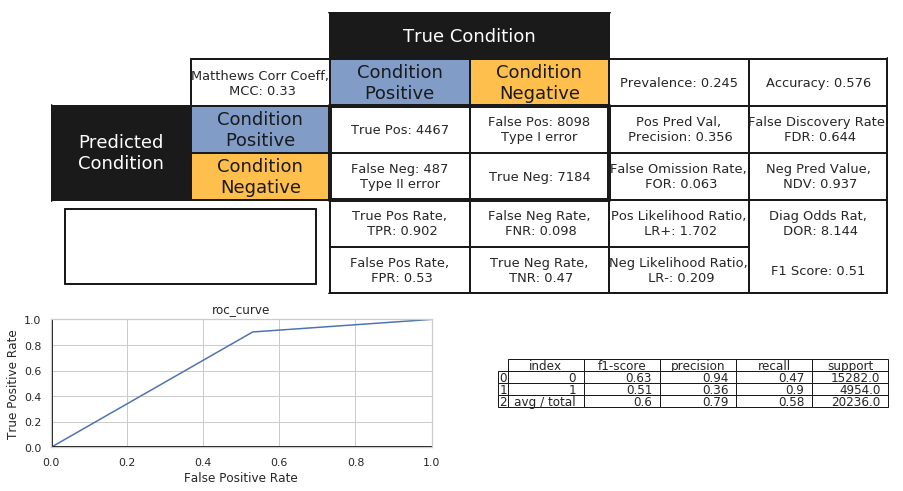

_______________When thershold is 0.3_______________


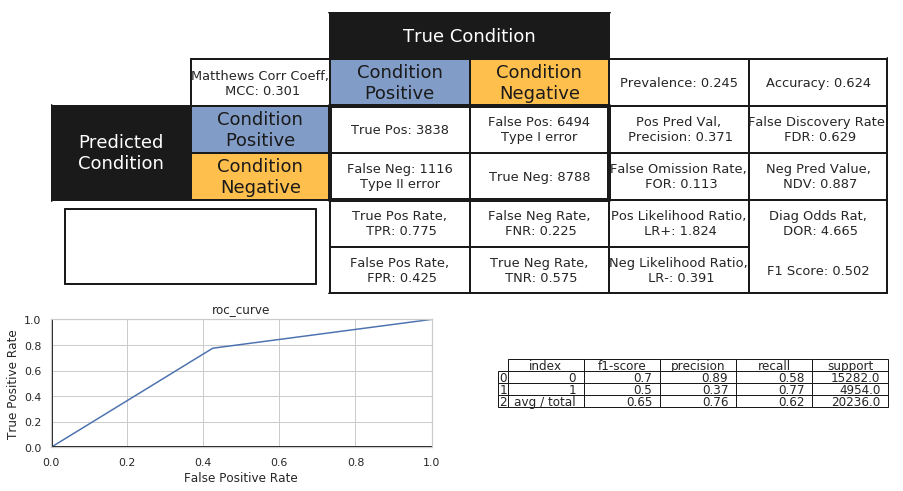

In [39]:
# Making the Confusion Matrix
i, j, step, ClassThres = 0.05, 0.3, 0.05, []
while i <= j: ClassThres.append(round(i,3)); i += step

print('_'*25+'On Test Data'+'_'*25)

for thresh in ClassThres:
    print('_'*15+'When thershold is {}'.format(thresh)+'_'*15)
    predicted = np.copy(ypred)
    predicted = [ 1 if ele > thresh else 0 for ele in predicted ]    
    plotConfusionMatrix(y_act=ytest, y_pred=predicted)

#### Disscussion
Threshold of about 0.25 seems to be the best

In [40]:
## Generating Result for other data
threshold = 0.27
xSubDF_Fil = xSubDF.loc[:,[col for col in xSubDF.columns.values if col != 'Index']]
ypred = xgbC.predict_proba(xSubDF_Fil)
ypred = [ ypred[i][1] for i in range(len(ypred)) ]
xSubDF.loc[:,'Class'] = ypred
xSubDF.loc[:,['Index', 'Class']].to_csv('result_xgb_probalistic_pred_Class.csv', sep='\t', index=False)
xSubDF.loc[:,'Class'] = [ 1 if ele > threshold else 0 for ele in ypred]
xSubDF.loc[:,['Index', 'Class']].to_csv('result_xgb_deterministic_pred_Class.csv', sep='\t', index=False)

### Logistic Regression
**Definition**: Logistic regression is a machine learning algorithm for classification. In this algorithm, the probabilities describing the possible outcomes of a single trial are modelled using a logistic function.

**Advantages**: Logistic regression is designed for this purpose (classification), and is most useful for understanding the influence of several independent variables on a single outcome variable.

**Disadvantages**: Works only when the predicted variable is binary, assumes all predictors are independent of each other, and assumes data is free of missing values.

In [41]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(n_jobs=1, random_state = seed)
lr.fit(xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=12345, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

_________________________On Test Data_________________________


/home/mohit/Documents/MyProject/MyProjectVirEnv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


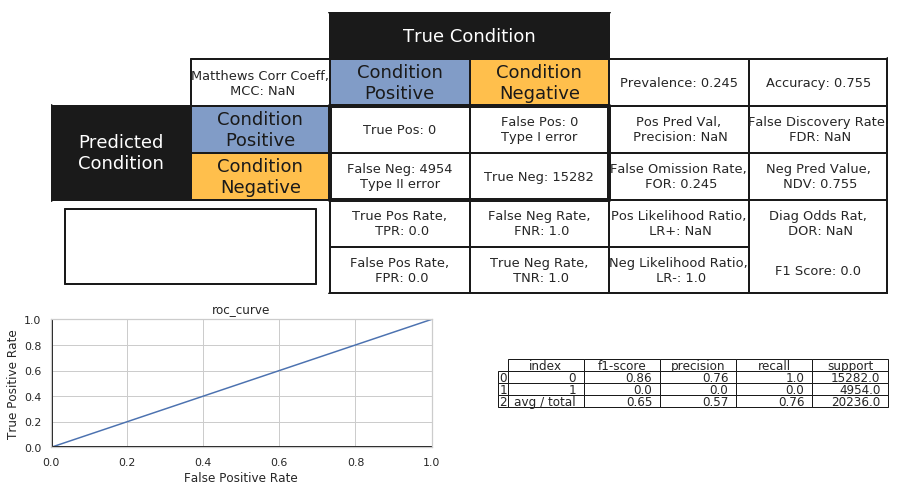

In [42]:
## Testing the Model
ypred = lr.predict(xtest)
## On Test Data
print('_'*25+'On Test Data'+'_'*25)
plotConfusionMatrix(y_act=ytest, y_pred=ypred)

### Naive Bayes
**Definition**: Naive Bayes algorithm based on Bayes’ theorem with the assumption of independence between every pair of features. Naive Bayes classifiers work well in many real-world situations such as document classification and spam filtering.

**Advantages**: This algorithm requires a small amount of training data to estimate the necessary parameters. Naive Bayes classifiers are extremely fast compared to more sophisticated methods.

**Disadvantages**: Naive Bayes is is known to be a bad estimator.

In [43]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(xtrain, ytrain)

GaussianNB(priors=None)

_________________________On Test Data_________________________


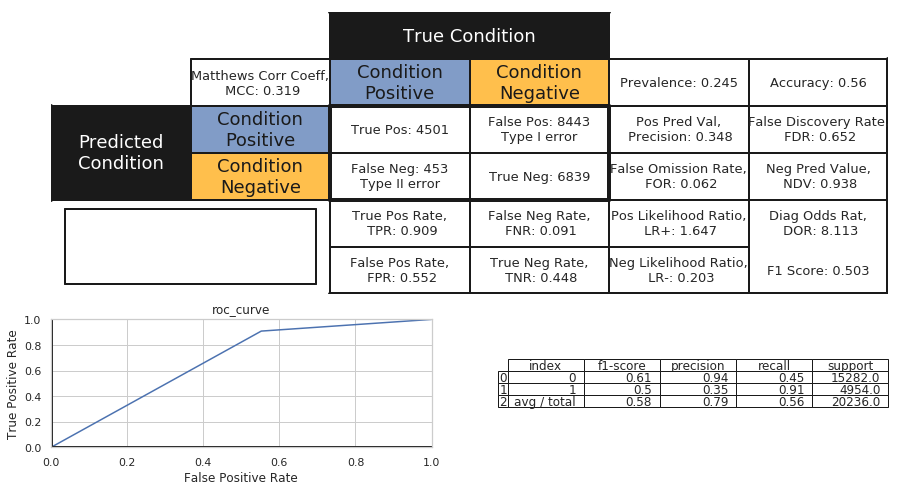

In [44]:
## Testing the Model
ypred = nb.predict(xtest)
## On Test Data
print('_'*25+'On Test Data'+'_'*25)
plotConfusionMatrix(y_act=ytest, y_pred=ypred)

In [45]:
xSubDF.drop(columns='Class', inplace=True)

## Generating Result for other data
xSubDF_Fil = xSubDF.loc[:,[col for col in xSubDF.columns.values if col != 'Index']]
xSubDF.loc[:,'Class'] = nb.predict(xSubDF_Fil)
xSubDF.loc[:,['Index', 'Class']].to_csv('result_naiveBayes_deterministic_pred_Class.csv', sep='\t', index=False)

### Stochastic Gradient Descent
**Definition**: Stochastic gradient descent is a simple and very efficient approach to fit linear models. It is particularly useful when the number of samples is very large. It supports different loss functions and penalties for classification.

**Advantages**: Efficiency and ease of implementation.

**Disadvantages**: Requires a number of hyper-parameters and it is sensitive to feature scaling.

In [46]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss='modified_huber', max_iter=None, tol=1e-3, shuffle=True, random_state=seed)
sgd.fit(xtrain, ytrain)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='modified_huber', max_iter=None,
       n_iter=None, n_jobs=1, penalty='l2', power_t=0.5,
       random_state=12345, shuffle=True, tol=0.001, verbose=0,
       warm_start=False)

_________________________On Test Data_________________________


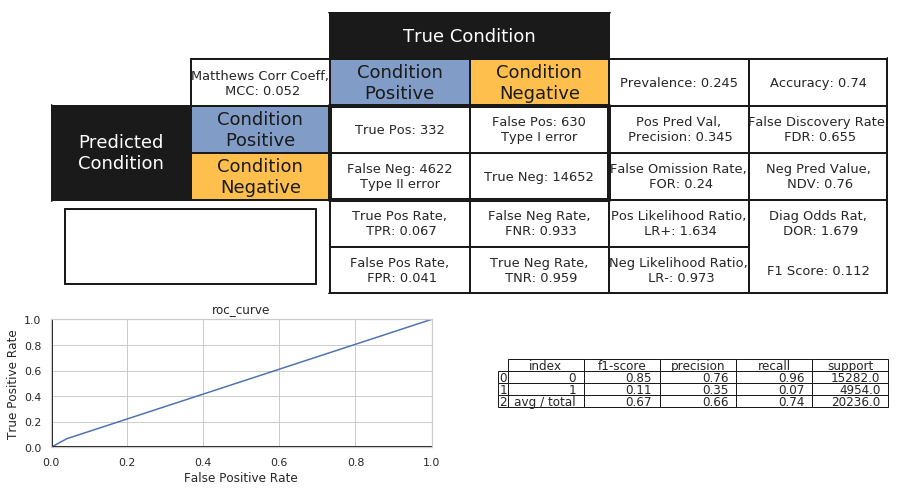

In [47]:
## Testing the Model
ypred = sgd.predict(xtest)
## On Test Data
print('_'*25+'On Test Data'+'_'*25)
plotConfusionMatrix(y_act=ytest, y_pred=ypred)

### K-Nearest Neighbours
**Definition**: Neighbours based classification is a type of lazy learning as it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the k nearest neighbours of each point.

**Advantages**: This algorithm is simple to implement, robust to noisy training data, and effective if training data is large.

**Disadvantages**: Need to determine the value of K and the computation cost is high as it needs to computer the distance of each instance to all the training samples.

In [48]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(xtrain, ytrain)

# Fitting K-NN to the Training set
# classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
# classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

_________________________On Test Data_________________________


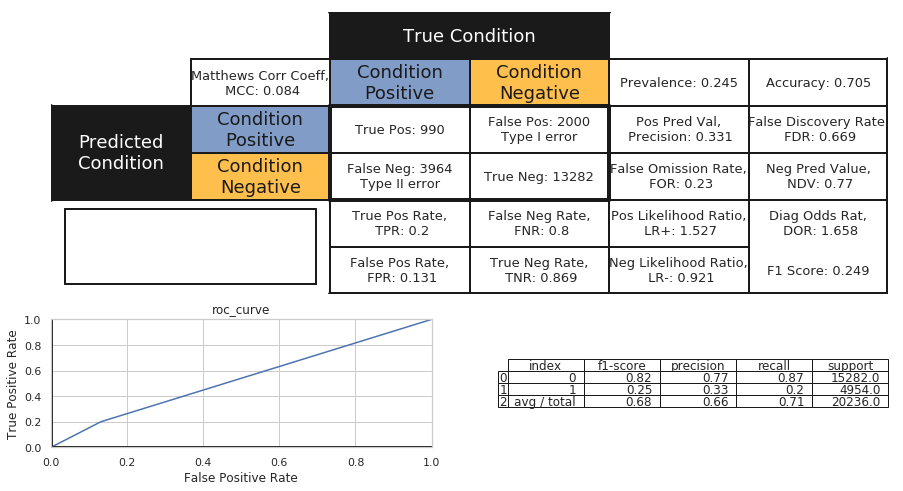

In [49]:
## Testing the Model
ypred = knn.predict(xtest)
## On Test Data
print('_'*25+'On Test Data'+'_'*25)
plotConfusionMatrix(y_act=ytest, y_pred=ypred)

### Decision Tree
**Definition**: Given a data of attributes together with its classes, a decision tree produces a sequence of rules that can be used to classify the data.

**Advantages**: Decision Tree is simple to understand and visualise, requires little data preparation, and can handle both numerical and categorical data.

**Disadvantages**: Decision tree can create complex trees that do not generalise well, and decision trees can be unstable because small variations in the data might result in a completely different tree being generated.

In [50]:
from sklearn.tree import DecisionTreeClassifier

# (criterion = 'entropy', random_state = 0)
dtree = DecisionTreeClassifier(random_state=seed)
dtree.fit(xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=12345, splitter='best')

_________________________On Test Data_________________________


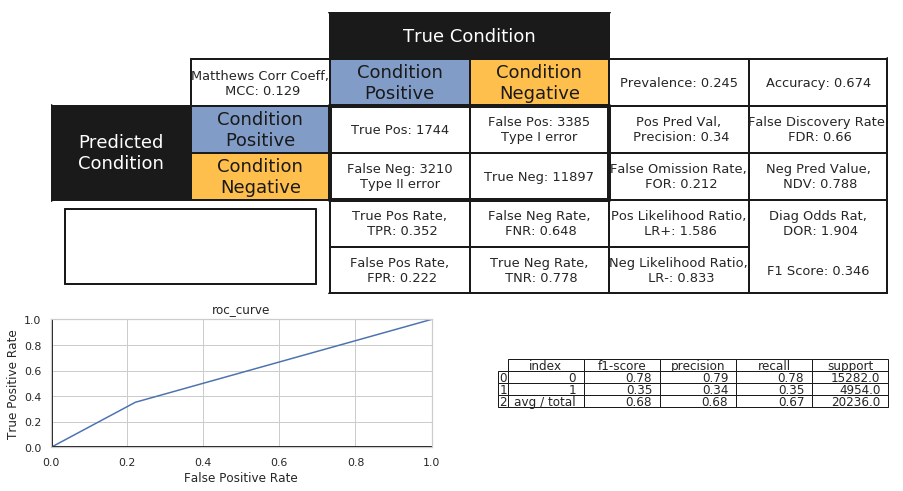

In [51]:
## Testing the Model
ypred = dtree.predict(xtest)
## On Test Data
print('_'*25+'On Test Data'+'_'*25)
plotConfusionMatrix(y_act=ytest, y_pred=ypred)

### Random Forest
**Definition**: Random forest classifier is a meta-estimator that fits a number of decision trees on various sub-samples of datasets and uses average to improve the predictive accuracy of the model and controls over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement.

**Advantages**: Reduction in over-fitting and random forest classifier is more accurate than decision trees in most cases.

**Disadvantages**: Slow real time prediction, difficult to implement, and complex algorithm.

In [52]:
from sklearn.ensemble import RandomForestClassifier

# RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
rfc = RandomForestClassifier(n_jobs=-1, random_state=seed)
rfc.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=12345, verbose=0,
            warm_start=False)

_________________________On Test Data_________________________


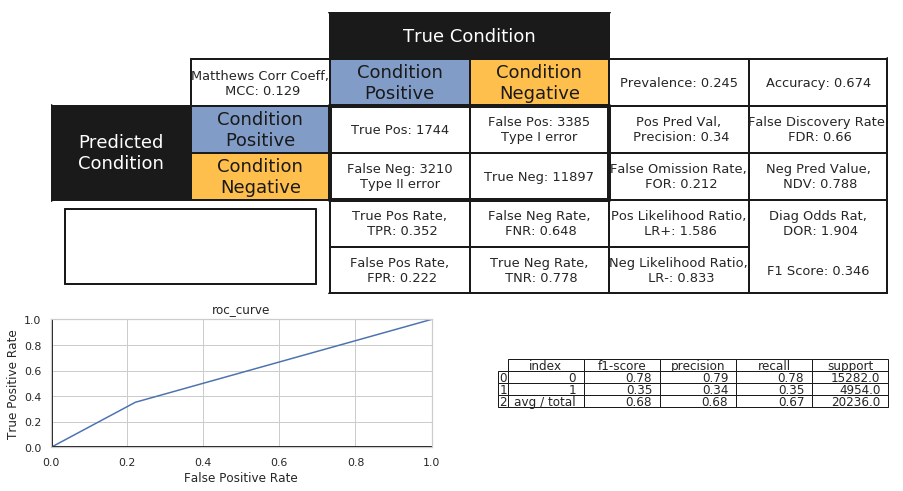

In [53]:
## Testing the Model
ypred = dtree.predict(xtest)
## On Test Data
print('_'*25+'On Test Data'+'_'*25)
plotConfusionMatrix(y_act=ytest, y_pred=ypred)

### AdaBoost
Pros
AdaBoost is easy to implement. It iteratively corrects the mistakes of the weak classifier and improves accuracy by combining weak learners. You can use many base classifiers with AdaBoost. AdaBoost is not prone to overfitting. This can be found out via experiment results, but there is no concrete reason available.

Cons
AdaBoost is sensitive to noise data. It is highly affected by outliers because it tries to fit each point perfectly. AdaBoost is slower compared to XGBoost.

In [54]:
from sklearn.ensemble import AdaBoostClassifier

adaBoost = AdaBoostClassifier(algorithm='SAMME.R', random_state=seed)
adaBoost.fit(xtrain, ytrain)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=12345)

_________________________On Test Data_________________________


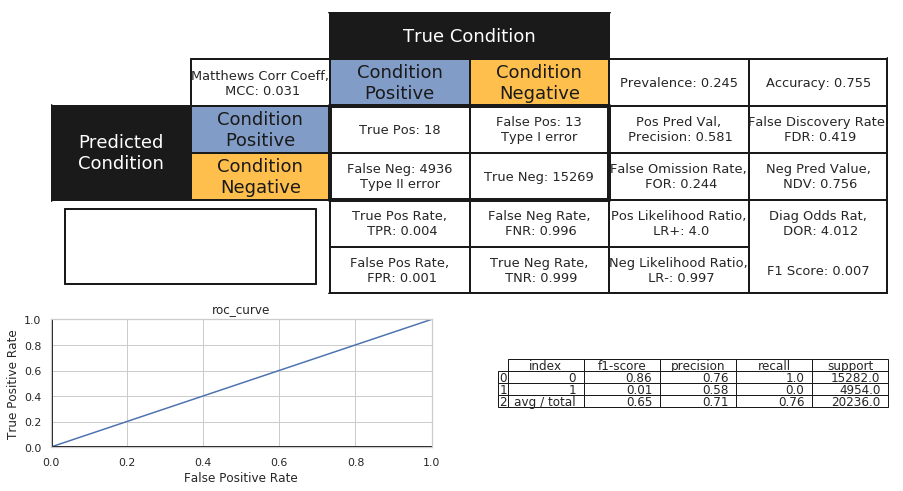

In [55]:
## Testing the Model
ypred = adaBoost.predict(xtest)
## On Test Data
print('_'*25+'On Test Data'+'_'*25)
plotConfusionMatrix(y_act=ytest, y_pred=ypred)

In [56]:
adaBoost = AdaBoostClassifier(algorithm='SAMME', random_state=seed)
adaBoost.fit(xtrain, ytrain)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=1.0,
          n_estimators=50, random_state=12345)

_________________________On Test Data_________________________


/home/mohit/Documents/MyProject/MyProjectVirEnv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


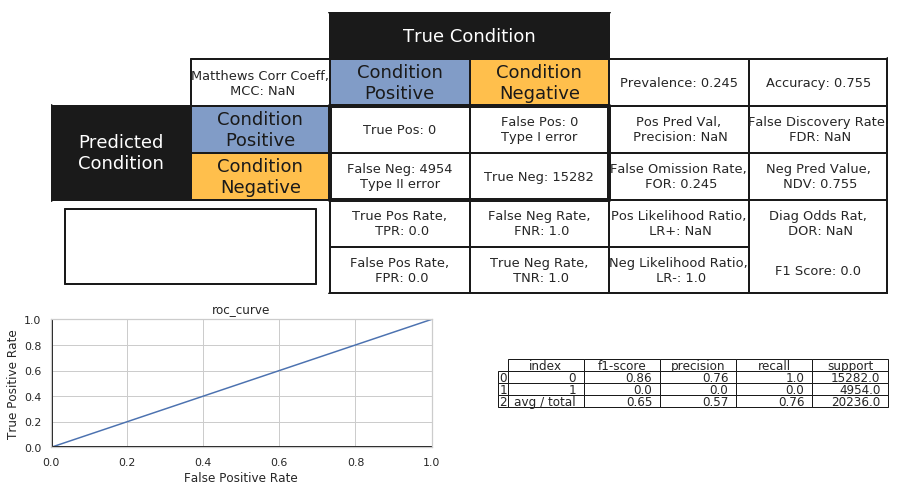

In [57]:
## Testing the Model
ypred = adaBoost.predict(xtest)
## On Test Data
print('_'*25+'On Test Data'+'_'*25)
plotConfusionMatrix(y_act=ytest, y_pred=ypred)

### Gradient Boosting
**Definition**: 

**Advantages**: 

**Disadvantages**:

In [58]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
clf.fit(xtrain, ytrain)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

_________________________On Test Data_________________________


/home/mohit/Documents/MyProject/MyProjectVirEnv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


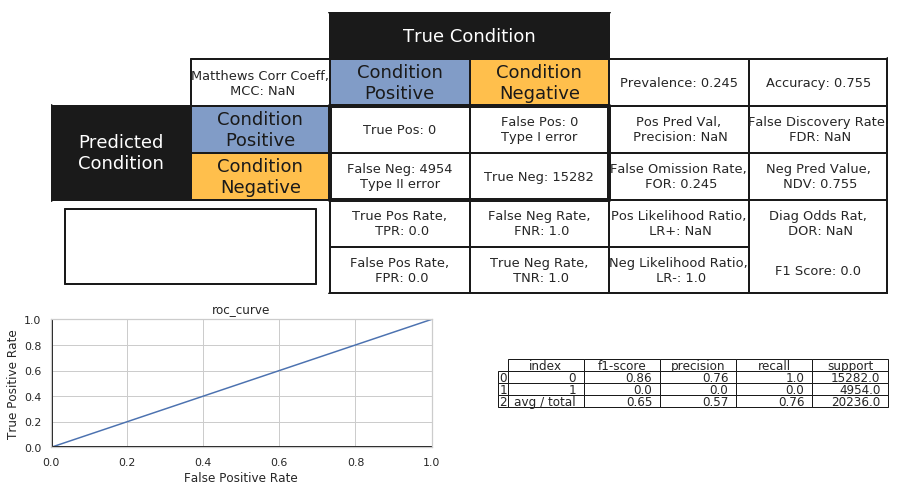

In [59]:
## Testing the Model
ypred = adaBoost.predict(xtest)
## On Test Data
print('_'*25+'On Test Data'+'_'*25)
plotConfusionMatrix(y_act=ytest, y_pred=ypred)

### Support Vector Machine
**Definition**: Support vector machine is a representation of the training data as points in space separated into categories by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall.

**Advantages**: Effective in high dimensional spaces and uses a subset of training points in the decision function so it is also memory efficient.

**Disadvantages**: The algorithm does not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation.

In [60]:
## Too Slow
# from sklearn.svm import SVC

# svm = SVC(kernel='linear', random_state=seed)
# svm.fit(xtrain, ytrain)

In [61]:
# ## Testing the Model
# ypred = svm.predict(xtest)
# ## On Test Data
# print('_'*25+'On Test Data'+'_'*25)
# plotConfusionMatrix(y_act=ytest, y_pred=ypred)

In [62]:
# # Fitting Kernel SVM to the Training set
# from sklearn.svm import SVC
# svm = SVC(kernel = 'rbf', random_state = 0)
# svm.fit(xtrain, ytrain)

<h1><center>Trying this problem with Clustering</h1>

Transforming Dimensions Using : PCA
Developing Model :: On provided Data


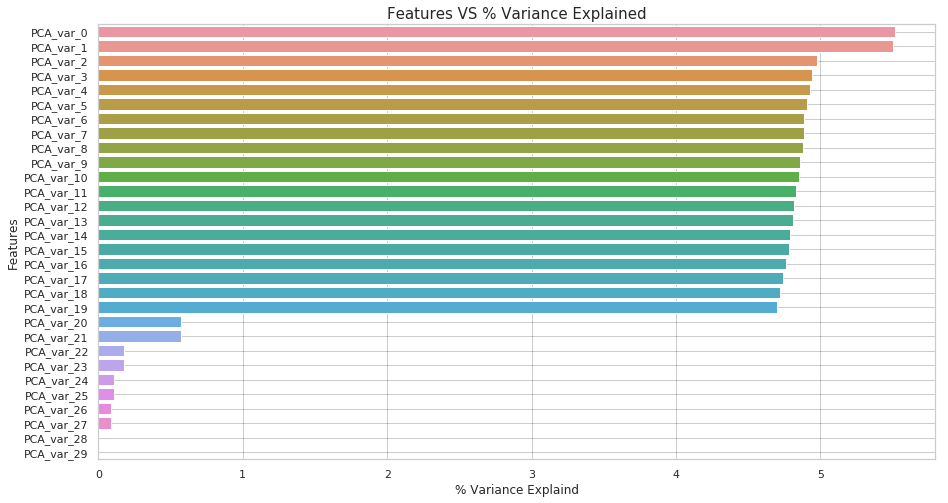

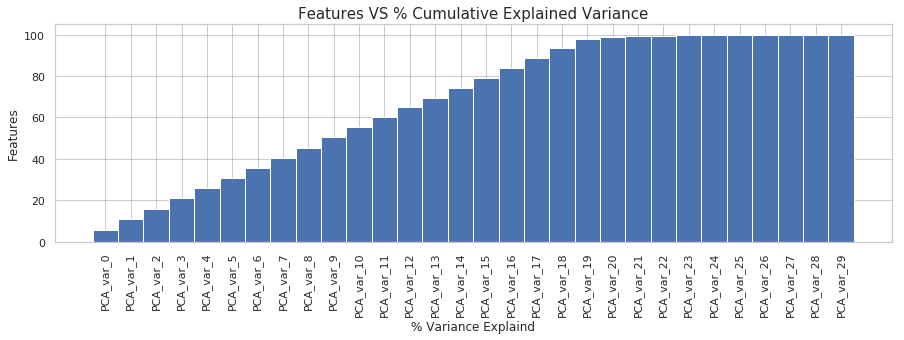

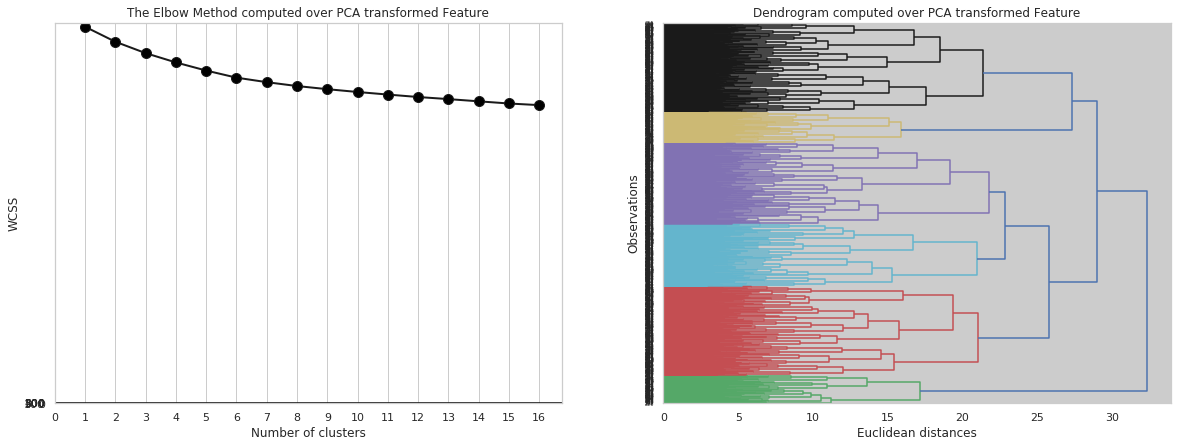

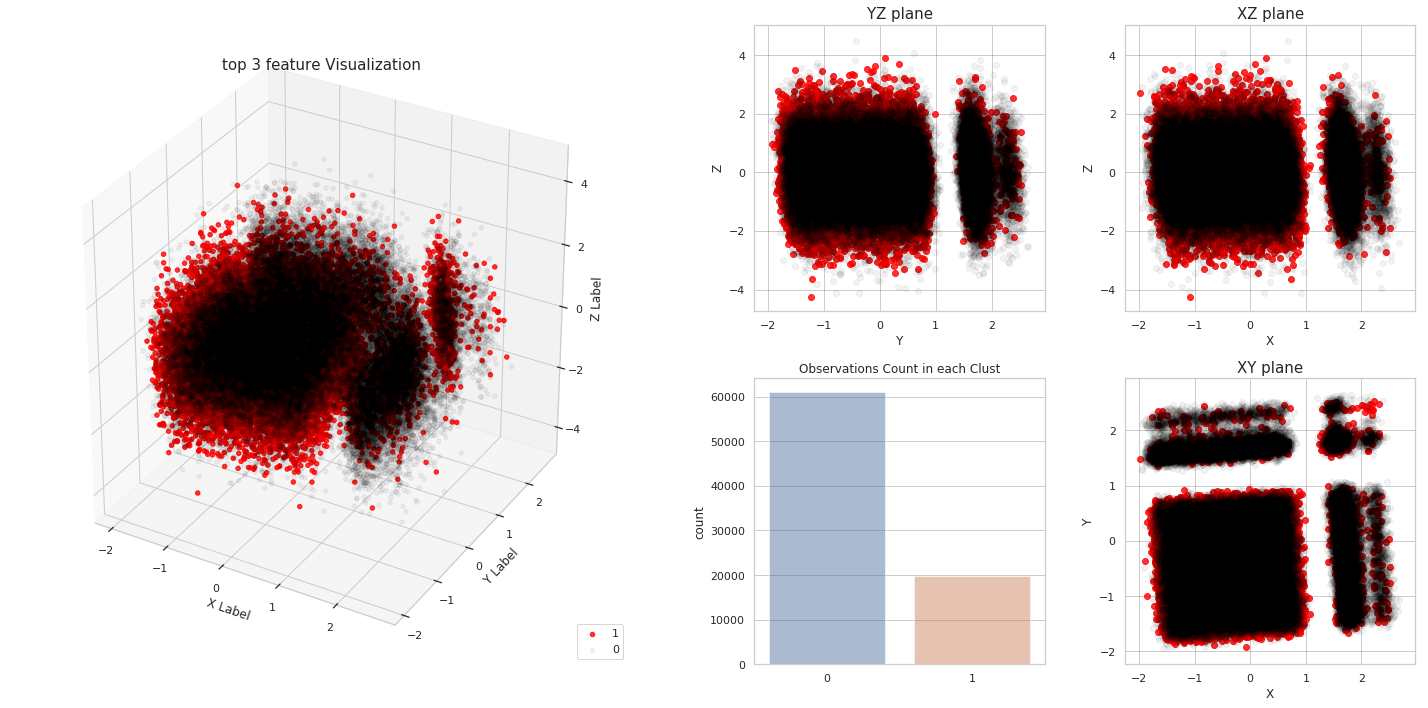

In [63]:
AlgoToUse = 'PCA' ##
## Getting the Configuration for the Algorithm
AlgoConfig = '''{'n_components': None, 'copy': True, 'whiten': False, 'svd_solver': 'auto', 'tol':0.0, 'iterated_power':'auto', 'random_state':None }'''
## http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA
## (n_components=None, copy=True, whiten=False, svd_solver=’auto’, tol=0.0, iterated_power=’auto’, random_state=None)

xtrain_DimTransf, Model = DimensionTransf(AlgoToUse, AlgoConfig, xtrain)
PlotExplainedVar(Model)
DetNoOfClusters(xtrain_DimTransf, AlgoToSelect='PCA transformed Feature')
DimenRed_Visual(xtrain_DimTransf, ytrain.reset_index(drop=True))

Developing Model :: On provided Data
Index(['KMeans_Predict'], dtype='object')


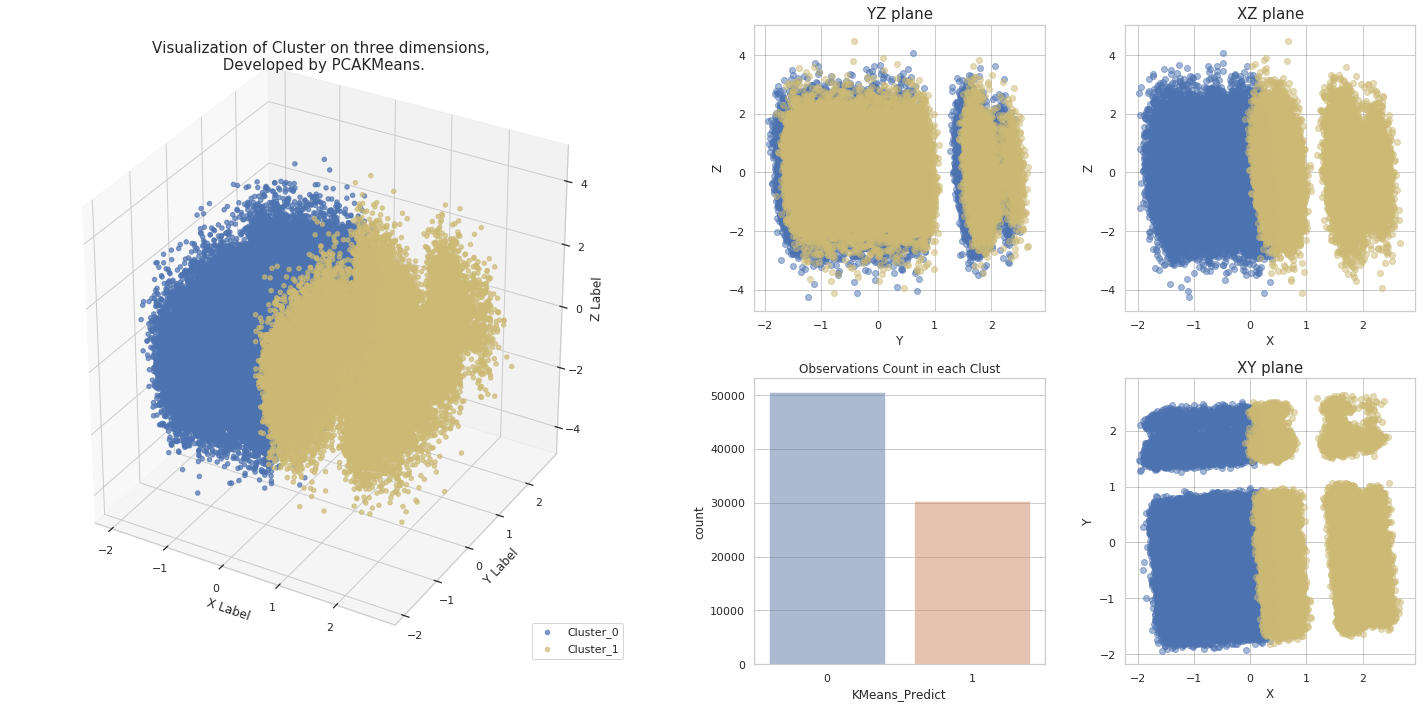

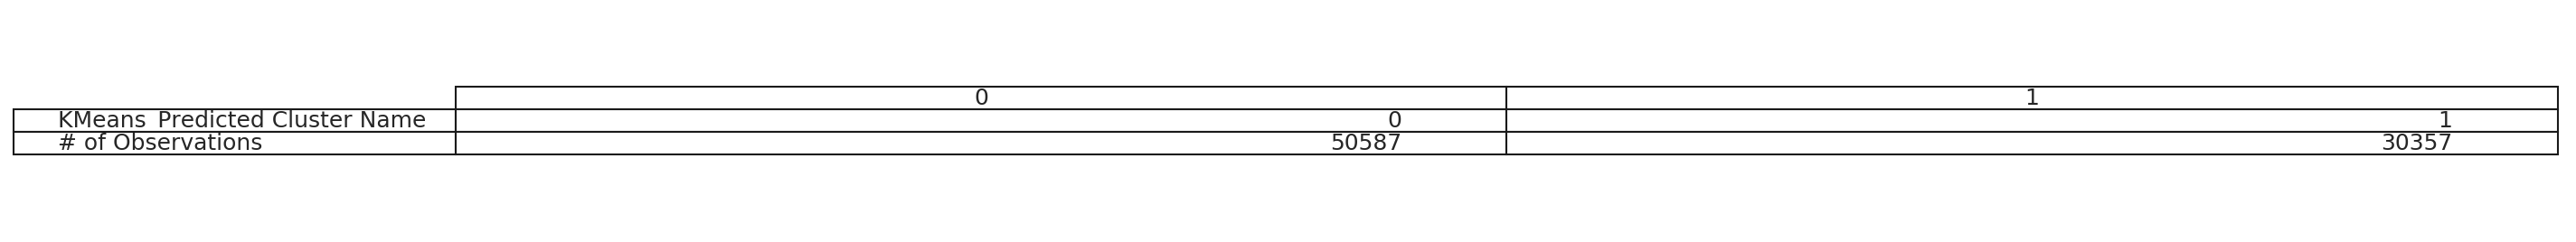

In [64]:
##  Two Cluster
ClustAlgo = 'KMeans'
ClustAlgo_ParamConfig = '''{'n_clusters':2, 'init':'k-means++', 'n_init': 10, 'max_iter': 300, 'tol': 0.0001}'''
## (n_clusters=8, init=’k-means++’, n_init=10, max_iter=300, tol=0.0001, precompute_distances=’auto’, verbose=0, random_state=None, copy_x=True, n_jobs=1, algorithm=’auto’)
## algorithm : “auto”, “full” or “elkan”, default=”auto”
xtrain_ClustPred = ClusterDevelopment(ClustAlgo, ClustAlgo_ParamConfig, xtrain_DimTransf)

VisualizeClusters(xtrain_ClustPred, AlgoToUse, ClustAlgo)

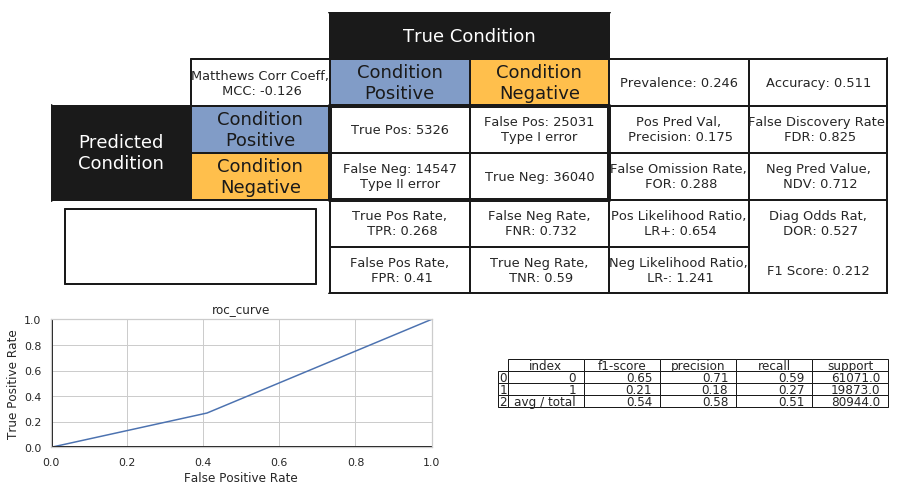

/home/mohit/Documents/MyProject/MyProjectVirEnv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:859: RuntimeWarning: overflow encountered in long_scalars
  return tk / np.sqrt(pk * qk) if tk != 0. else 0.
/home/mohit/Documents/MyProject/MyProjectVirEnv/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:859: RuntimeWarning: invalid value encountered in sqrt
  return tk / np.sqrt(pk * qk) if tk != 0. else 0.


Silhouette Coefficient Error:  


{'Timestamp': '19/03/17 20hr:17min(GMT)',
 'Algorithm': '---',
 'NoOfCluster': 2,
 'Cust_EntropyScore': 0.83858,
 'AdjustedRandIndex': -0.01596,
 'AdjustedMutualInfoScore': 0.01243,
 'NormalizedMutualInfoScore': 0.01355,
 'HomogenityScore': 0.01477,
 'CompletenessScore': 0.01244,
 'V-measureScore': 0.0135,
 'FowlkesMallowsScore': nan,
 'SilhouetteCoefficient': None,
 'CalinskiHarabazScore': 3269.47658}

In [65]:
## Evaluating Results
ypred = xtrain_ClustPred[xtrain_ClustPred.filter(like='_Predict').columns.values[0]]

# level_map = {1:0, 0:1}
# ypred = ypred.map(level_map)

plotConfusionMatrix(ytrain, ypred)

ClusterEvalScores = ComputingClusterEvalMetric(xtrain_DimTransf, ytrain, ypred)
# ClusterEvalScores['Algorithm'] = AlgoName
ClusterEvalScores

#### Discussion
Cool, This unsupervised learning is performing the best in terms of finding the True Positive

In [66]:
xSubDF.drop(columns='Class', inplace=True)

## Generating Result for other data
xSubDF_Fil = xSubDF.loc[:,[col for col in xSubDF.columns.values if col != 'Index']]

AlgoToUse = 'PCA' ##
AlgoConfig = '''{'n_components': None, 'copy': True, 'whiten': False, 'svd_solver': 'auto', 'tol':0.0, 'iterated_power':'auto', 'random_state':None }'''
xSubDF_DimTransf, Model = DimensionTransf(AlgoToUse, AlgoConfig, xSubDF_Fil)

ClustAlgo = 'KMeans'
ClustAlgo_ParamConfig = '''{'n_clusters':2, 'init':'k-means++', 'n_init': 10, 'max_iter': 300, 'tol': 0.0001}'''
xSubDF_ClustPred = ClusterDevelopment(ClustAlgo, ClustAlgo_ParamConfig, xSubDF_DimTransf)

ypred = xtrain_ClustPred[xSubDF_ClustPred.filter(like='_Predict').columns.values[0]]
level_map = {1:0, 0:1} ## Cluster name can get reversed
xSubDF.loc[:,'Class'] = ypred.map(level_map)

xSubDF.loc[:,['Index', 'Class']].to_csv('result_KMeans_deterministic_pred_Class(label_maybe_inverse).csv', sep='\t', index=False)

Transforming Dimensions Using : PCA
Developing Model :: On provided Data
Developing Model :: On provided Data


<h1><center>Stacking Multiple Algorithm</h1>

In [67]:
''' will do later '''

' will do later '

In [68]:
1/0

ZeroDivisionError: division by zero

<h1><center> -----------  Work End  ----------- </h1>

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel



## Importing Packages related to Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

## Importing Packages related to Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from xgboost import XGBClassifier

## Importing Other Packages
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from time import time

Cnt_Vec = CountVectorizer()
TfIdf_Vec = TfidfVectorizer()
Hsh_Vec = HashingVectorizer()

lr = LogisticRegression()
LSVC = LinearSVC()
MNB = MultinomialNB()
RC = RidgeClassifier()
PAC = PassiveAggressiveClassifier()

LogReg = LogisticRegression(),
LinSVC = LinearSVC(),
LinSVC_l1FeaSel = Pipeline([ ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))), ('classification', LinearSVC(penalty="l2"))])
MultiNB = MultinomialNB(),
BernNB = BernoulliNB(),
RidCla = RidgeClassifier(),
AdBooCla = AdaBoostClassifier(),
Perce = Perceptron(),
PassAggCla = PassiveAggressiveClassifier(),
NeaCent = NearestCentroid()

XGB_Cla = XGBClassifier()

In [ ]:
if WorkspaceBasedCheckPt(ChPt):
    
    # http://scikit-learn.org/stable/auto_examples/plot_compare_reduction.html
    ## http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    ## Printing VariableName as string
    def varname( var, dir=locals()):
        return [ key for key, val in dir.items() if id( val) == id( var)]


    ## Defining the function for the grid search
    def GridSearchModsPairs_2(x_TrainDF, y_TrainDF, vectorizer_classifier_list):
        AllResult_DF = pd.DataFrame()
        BestResult_DF = pd.DataFrame() ## Algo pair wise

        for i in range(len(vectorizer_classifier_list)):
            t0 = time()
            vectori = varname(vectorizer_classifier_list[i]['Vectorizer'])[0]
            classif = varname(vectorizer_classifier_list[i]['Classifier'])[0]
            print('Working on the Following pair:', vectori, classif)

            param_grid = [vectorizer_classifier_list[i]['params']]
            Mods_Pipe = Pipeline([ ('Vectorizer', vectorizer_classifier_list[i]['Vectorizer']), ('Classifier', vectorizer_classifier_list[i]['Classifier']) ])
            Mods_GridSearchCV = GridSearchCV(Mods_Pipe, param_grid=param_grid, cv=2, n_jobs=1, iid= False, return_train_score=False, verbose = 1)# , scoring='accuracy'
            Mods_GridSearchCV.fit(x_TrainDF, y_TrainDF) ## Won't be using Holdout CrossValidata ##x_ValDF, y_ValDFb

            IterationTime = time() - t0
            print("Iteration time: {0:.2f}s".format(IterationTime))        

            tempDF = pd.DataFrame(Mods_GridSearchCV.cv_results_)
            tempDF['Vectorizer'] = [vectori for i in range(len(tempDF))]
            tempDF['Classifier'] = [classif for i in range(len(tempDF))]
            if AllResult_DF.shape == (0,0):
                AllResult_DF = tempDF.copy()
            else:
                AllResult_DF = AllResult_DF.append(tempDF, ignore_index=True)

            temp_dict = {
            'Vectorizer' : vectori,
            'Classifier' : classif,
            'BestScore' :  Mods_GridSearchCV.best_score_,
            'BestParameters' : str(Mods_GridSearchCV.best_params_)
            }
            tempDF2 = pd.DataFrame(temp_dict, columns=['Vectorizer', 'Classifier', 'BestScore', 'BestParameters'], index = [i])
            if BestResult_DF.shape == (0,0):
                BestResult_DF = tempDF2.copy()
            else:
                BestResult_DF = BestResult_DF.append(tempDF2, ignore_index=True)
    #     print(Result_DF.shape)
    #     Result_DF.head()

        return AllResult_DF, BestResult_DF

In [ ]:
if WorkspaceBasedCheckPt(ChPt):
    
    %%time
    vectorizer_classifier = [{'Vectorizer': Cnt_Vec,
                              'Classifier': lr,
                              'params': {'Vectorizer__max_features': [i for i in range(10000, 15001, 10000)], 
                                            'Vectorizer__stop_words': [None, 'english'], 
                                            'Vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
                                            'Classifier__fit_intercept': [True]
                                           }
                             },
                             {'Vectorizer': TfIdf_Vec, 
                              'Classifier': lr,
                              'params': {'Vectorizer__max_features': [i for i in range(10000, 15001, 10000)], 
                                            'Vectorizer__stop_words': [None, 'english'], 
                                            'Vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
                                            'Classifier__fit_intercept': [True]
                                           }
                             },
                             {'Vectorizer': Hsh_Vec, 
                              'Classifier': lr,
                              'params': {'Vectorizer__n_features': [i for i in range(10000, 15001, 10000)], 
                                            'Vectorizer__stop_words': [None, 'english'], 
                                            'Vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
                                            'Classifier__fit_intercept': [True]
                                           }
                             },

                             {'Vectorizer': TfIdf_Vec,
                              'Classifier': LinSVC_l1FeaSel,
                              'params': {'Vectorizer__max_features': [i for i in range(100000, 100001, 10000)], 
                                            'Vectorizer__stop_words': [None], 
                                            'Vectorizer__ngram_range': [(1, 2)]
                                           }
                             },

                             {'Vectorizer': TfIdf_Vec,
                              'Classifier': XGB_Cla,
                              'params': {'Vectorizer__max_features': [i for i in range(100000, 100001, 10000)], 
                                            'Vectorizer__stop_words': [None], 
                                            'Vectorizer__ngram_range': [(1, 2)]
                                           }
                             }
                             ]

    AllResult_DF, BestResult_DF = GridSearchModsPairs_2(x_TrainDF, y_TrainDF, vectorizer_classifier)

    display(BestResult_DF)
    print("Total number of models that were trained:", len(AllResult_DF))
    display(AllResult_DF)
    
    
if WorkspaceBasedCheckPt(ChPt):
    
    # sns.set(rc={'figure.figsize':(11.7,5.27)})
    # sns.set_style('whitegrid')

    # fig, ax = plt.subplots(figsize=(10,5))

    # sns.set_style('ticks')
    # fig, ax = plt.subplots()
    # # the size of A4 paper
    # fig.set_size_inches(11.7, 8.27)

    VarToUseInHUE = ["Vectorizer", "Classifier", "param_Vectorizer__stop_words", "param_Vectorizer__ngram_range", "param_Vectorizer__max_features", "param_Vectorizer__n_features"]
    VarName = ["Vectorizer", "Classifier", "Stopwords", "ngram_range", "max_features", "n_features"]
    for plot in range(len(VarToUseInHUE)):

        # sns.set_style('whitegrid')
        MissingValue = 'NA'
        if VarName[plot] == "Stopwords":
            MissingValue = 'Not Removed'
        if VarName[plot] == "max_features" or VarName[plot] == "n_features":
            MissingValue = np.nan

        %config InlineBackend.figure_format = 'retina'
        sns.set()
        sns.pairplot(x_vars=["mean_fit_time"], y_vars=["mean_test_score"], data=AllResult_DF.fillna(MissingValue), hue= VarToUseInHUE[plot], 
                     size=5, aspect = 2) #, palette = "Set2", markers=["o", "s", "D"]
        plt.title("Accuracy VS Time Taken - {}".format(VarName[plot]))
        plt.xlabel("Mean Time Taken in Training")
        plt.ylabel("Mean Accuracy in Cross Validation'")

        # plt.legend(bbox_to_anchor=(1, 1), loc=2)
        # plt.xticks(rotation=-45)
        # plt.ylim(0, None)
        plt.xlim(0, None)
        plt.show()

In [ ]:
if WorkspaceBasedCheckPt(ChPt):
    
    print("param: Vectorizer__ngram_range Vectorizer__stop_words Classifier__fit_intercept Vectorizer__max_features'")
    from bokeh.plotting import figure, output_file, show, ColumnDataSource
    from bokeh.models import HoverTool
    output_file("color_scatter.html")

    ### converting to Creates labels for hover
    allLi = []
    for i in Result_DF["params"]:
        ele = []
        for k in i.keys():
            ele.append(str(i[k]))
        allLi.append("\n".join(ele))
    # allLi
    source = ColumnDataSource(data=dict(
        x = AllResult_DF['mean_fit_time'],
        y = AllResult_DF['mean_test_score'] * 100,
        Param = allLi,
    ))

    hover = HoverTool(tooltips=[
        ("(x,y)", "($x, $y)"),
        ("Param", "@Param"),
    ]) #     ("index", "$index"),

    # radii = np.random.random(size=N) * 1.5
    # colors = [
    #     "#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x, 30+2*y)
    # ]

    # TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
    p = figure(plot_width=700, plot_height=400, tools= [hover], title="Accuracy vs Time Taken", 
               y_axis_label='Mean Accuracy in Cross Validation', x_axis_label='Mean Time Taken for Training') #, x_range=(0, 70000), y_range=(0, 100)

    p.circle('x', 'y', source=source, color = 'red', size=5, alpha=0.6)

    show(p)

    # print("Parameter Combination for best Score:", Mods_GridSearchCV.best_params_, "\nBest Accuracy:", 100*Mods_GridSearchCV.best_score_)

In [ ]:
## Parameter Tuning

In [ ]:
from sklearn.grid_search import GridSearchCV   #Perforing grid search

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
## Ensemble

if WorkspaceBasedCheckPt(ChPt):
    
    from sklearn.ensemble import VotingClassifier

    clf1 = LogisticRegression()
    clf2 = LinearSVC()
    clf3 = MultinomialNB()
    clf4 = RidgeClassifier()
    clf5 = PassiveAggressiveClassifier()
    eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('mnb', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')


    %%time
    vectorizer_classifier = [{'Vectorizer': Cnt_Vec,
                              'Classifier': eclf,
                              'params': {'Vectorizer__max_features': [i for i in range(10000, 15001, 10000)], 
                                            'Vectorizer__stop_words': [None, 'english'], 
                                            'Vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]
                                           }
                             }
                             ]

    EnsembleResult_DF, EnsembleBestResult_DF = GridSearchModsPairs_2(x_TrainDF, y_TrainDF, vectorizer_classifier)

    display(EnsembleBestResult_DF)
    print("Total number of models that were trained(Without including CrossValidation):", len(EnsembleResult_DF))
    display(EnsembleResult_DF)

### Artificial Neural Network
**Definition**: 

**Advantages**: 

**Disadvantages**: 

In [ ]:
# ANN!
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu', input_dim = 46))

# Adding the second hidden layer
classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train[:, [i for i in range(0, X_train.shape[1]) if i != 0]], y_train, batch_size = 10, epochs = 1)

In [ ]:
# Part 3 - Making predictions and evaluating the model

# Predicting the Test set results
y_pred = classifier.predict(X_test[:, [i for i in range(0, X_test.shape[1]) if i != 0]])
# y_pred = (y_pred > 0.5)

# # Making the Confusion Matrix
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, y_pred)

In [ ]:
X_test[:,"PredictedValue"].reset_index(drop=True) = classifier.predict(X_test[:, [i for i in range(0, X_test.shape[1]) if i != 0]])

In [ ]:
FeatureToKeep = ["apidata__zpsbd6", "isBotHits", "PredictedValue"]
TestResult[[i for i in FeatureToKeep]]
# [i for i in list(TestResult.columns) if i == FeatureToKeep]
# TestResult[[i for i in list(TestResult.columns) if i == FeatureToKeep]]

In [ ]:
# Evaluating the ANN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense
def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu', input_dim = 46))
    classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 10, epochs = 10)
accuracies = cross_val_score(estimator = classifier, X = X_train[:, [i for i in range(0, X_train.shape[1]) if i != 0]], y = y_train, cv = 5, n_jobs = -1)
mean = accuracies.mean()
variance = accuracies.std()

In [ ]:
# Improving the ANN
# Dropout Regularization to reduce overfitting if needed
## importing the libraries
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

## Initializing the ANN
#classifier.add(Dense(Output_dim/units = 10, init = 'uniform', activation = 'relu', input_dim = 46))

# Initialising the ANN
classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu', input_dim = 46))
classifier.add(Dropout(p=0.1))
# Adding the second hidden layer
classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(p=0.1))
# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# Fitting the ANN to the Training set
classifier.fit(X_train[:, [i for i in range(0, X_train.shape[1]) if i != 0]], y_train, batch_size = 10, epochs = 10)

In [ ]:
# Tuning the ANN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
def build_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu', input_dim = 46))
    classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [25, 32],
              'epochs': [10, 50],
              'optimizer': ['adam', 'rmsprop']}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5)
grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

### LightGBM
**Definition**: 

**Advantages**: 

**Disadvantages**:

In [ ]:
import lightgbm as lgb

train_data=lgb.Dataset(x_train,label=y_train)
#setting parameters for lightgbm
param = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
param['metric'] = ['auc', 'binary_logloss']

#Here we have set max_depth in xgb and LightGBM to 7 to have a fair comparison between the two.

#training our model using light gbm
num_round=50
start=datetime.now()
lgbm=lgb.train(param,train_data,num_round)
stop=datetime.now()

#Execution time of the model
execution_time_lgbm = stop-start
execution_time_lgbm

#predicting on test set
ypred2=lgbm.predict(x_test)
ypred2[0:5]  # showing first 5 predictions


#converting probabilities into 0 or 1
for i in range(0,9769):
    if ypred2[i]>=.5:       # setting threshold to .5
       ypred2[i]=1
    else:  
       ypred2[i]=0

## Evaluation
### Confusion Matrix

In [ ]:
from sklearn.model_selection import cross_validate

from sklearn.metrics import roc_auc_score

#calculating roc_auc_score for xgboost
auc_xgb =  roc_auc_score(y_test,ypred)
auc_xgb

In [ ]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print "null accuracy: {0:.2f}%".format(null_accuracy*100)
    print "accuracy score: {0:.2f}%".format(accuracy*100)
    if accuracy > null_accuracy:
        print "model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100)
    elif accuracy == null_accuracy:
        print "model has the same accuracy with the null accuracy"
    else:
        print "model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100)
    print "train and test time: {0:.2f}s".format(train_test_time)
    print "-"*80
    return accuracy, train_test_time


In [ ]:
def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['negative', 'positive'],
                         columns=['predicted_negative','predicted_positive'])
    print "null accuracy: {0:.2f}%".format(null_accuracy*100)
    print "accuracy score: {0:.2f}%".format(accuracy*100)
    if accuracy > null_accuracy:
        print "model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100)
    elif accuracy == null_accuracy:
        print "model has the same accuracy with the null accuracy"
    else:
        print "model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100)
    print "-"*80
    print "Confusion Matrix\n"
    print confusion
    print "-"*80
    print "Classification Report\n"
    print classification_report(y_test, y_pred, target_names=['negative','positive'])

In [ ]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
accuracies.mean()
accuracies.std()